In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import math
from io import BytesIO
import base64

sns.set_theme(style="darkgrid")


# Análisis de Reservas de Hotel

## Introducción
Este proyecto tiene como objetivo realizar un análisis exhaustivo de un conjunto de datos de reservas de hotel. El análisis incluirá la exploración de datos (EDA), un análisis de negocio centrado en el impacto de las cancelaciones en los ingresos, y el entrenamiento y evaluación de modelos de clasificación para predecir el estado de las reservas.


## Diccionario de Datos

Los datos utilizados en este análisis provienen de Kaggle. A continuación, se detalla la fuente y una breve descripción de las columnas:


| Columna | Descripción | Tipo de Variable |
|---|---|---|
| `Booking_ID` | Identificador único de la reserva. | Numérica |
| `no_of_adults` | Número de adultos en la reserva. | Numérica Discreta |
| `no_of_children` | Número de niños en la reserva. | Numérica Discreta |
| `no_of_weekend_nights` | Número de noches de fin de semana reservadas. | Numérica Discreta |
| `no_of_week_nights` | Número de noches de entre semana reservadas. | Numérica Discreta |
| `type_of_meal_plan` | Tipo de plan de comidas. | Categórica |
| `required_car_parking_space` | Indica si se requiere espacio de estacionamiento. | Categórica Binaria |
| `room_type_reserved` | Tipo de habitación reservada. | Categórica |
| `lead_time` | Número de días entre la fecha de reserva y la fecha de llegada. | Numérica Discreta |
| `arrival_year` | Año de llegada. | Temporal |
| `arrival_month` | Mes de llegada. | Temporal |
| `arrival_date` | Día de llegada. | Temporal |
| `market_segment_type` | Tipo de segmento de mercado (ej. Online, Offline, etc.). | Categórica |
| `repeated_guest` | Indica si el huésped es recurrente. | Categórica Binaria |
| `no_of_previous_cancellations` | Número de cancelaciones previas del huésped. | Numérica Discreta |
| `no_of_previous_bookings_not_canceled` | Número de reservas previas no canceladas por el huésped. | Numérica Discreta |
| `avg_price_per_room` | Precio promedio por habitación por noche. | Numérica Continua |
| `no_of_special_requests` | Número de solicitudes especiales realizadas por el huésped. | Numérica Discreta |
| `booking_status` | Estado de la reserva. | Categórica Binaria |

- **Fuente de los datos**: [Hotel Reservations Classification Dataset](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset?resource=download)


# EDA

## Variables numéricas

In [2]:
df = pd.read_csv('data/Hotel Reservations.csv')

### Estadísticos básicos

In [3]:
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
temporal_cols = ['arrival_year', 'arrival_month', 'arrival_date']
numerical_cols = [col for col in numerical_cols if col not in temporal_cols]

if 'Booking_ID' in numerical_cols:
    numerical_cols.remove('Booking_ID')

desc_df = df[numerical_cols].describe().T

styled_table = (
    desc_df.style
    .format("{:.2f}")
    .set_properties(**{
        'text-align': 'center',
        'white-space': 'normal',
        'word-wrap': 'break-word',
        'height': 'auto',
        'vertical-align': 'middle',
        'padding': '5px 3px'
    })
    .set_table_attributes('border="1" class="dataframe styled-table" style="border-collapse:collapse; width:100%;"')
)

html_table = styled_table.to_html()

full_html = f"""
<style>
    .styled-table {{
        width: 100%;
        table-layout: auto;
        border-collapse: collapse;
        font-size: 12px;
    }}
    .styled-table th,
    .styled-table td {{
        white-space: normal;
        word-wrap: break-word;
        text-align: center;
        vertical-align: middle;
        padding: 12px 6px;
        min-width: 90px;
        max-width: 200px;
    }}
</style>

<div style="display: flex; justify-content: center; width: 100%; margin: 5px 0;">
    <div style="width: 80%; overflow-x: auto;">
        {html_table}
    </div>
</div>
"""

display(HTML(full_html))

,count,mean,std,min,25%,50%,75%,max
no_of_adults,36275.00,1.84,0.52,0.00,2.00,2.00,2.00,4.00
no_of_children,36275.00,0.11,0.40,0.00,0.00,0.00,0.00,10.00
no_of_weekend_nights,36275.00,0.81,0.87,0.00,0.00,1.00,2.00,7.00
no_of_week_nights,36275.00,2.20,1.41,0.00,1.00,2.00,3.00,17.00
required_car_parking_space,36275.00,0.03,0.17,0.00,0.00,0.00,0.00,1.00
lead_time,36275.00,85.23,85.93,0.00,17.00,57.00,126.00,443.00
repeated_guest,36275.00,0.03,0.16,0.00,0.00,0.00,0.00,1.00
no_of_previous_cancellations,36275.00,0.02,0.37,0.00,0.00,0.00,0.00,13.00
no_of_previous_bookings_not_canceled,36275.00,0.15,1.75,0.00,0.00,0.00,0.00,58.00
avg_price_per_room,36275.00,103.42,35.09,0.00,80.30,99.45,120.00,540.00


### Distribuciones


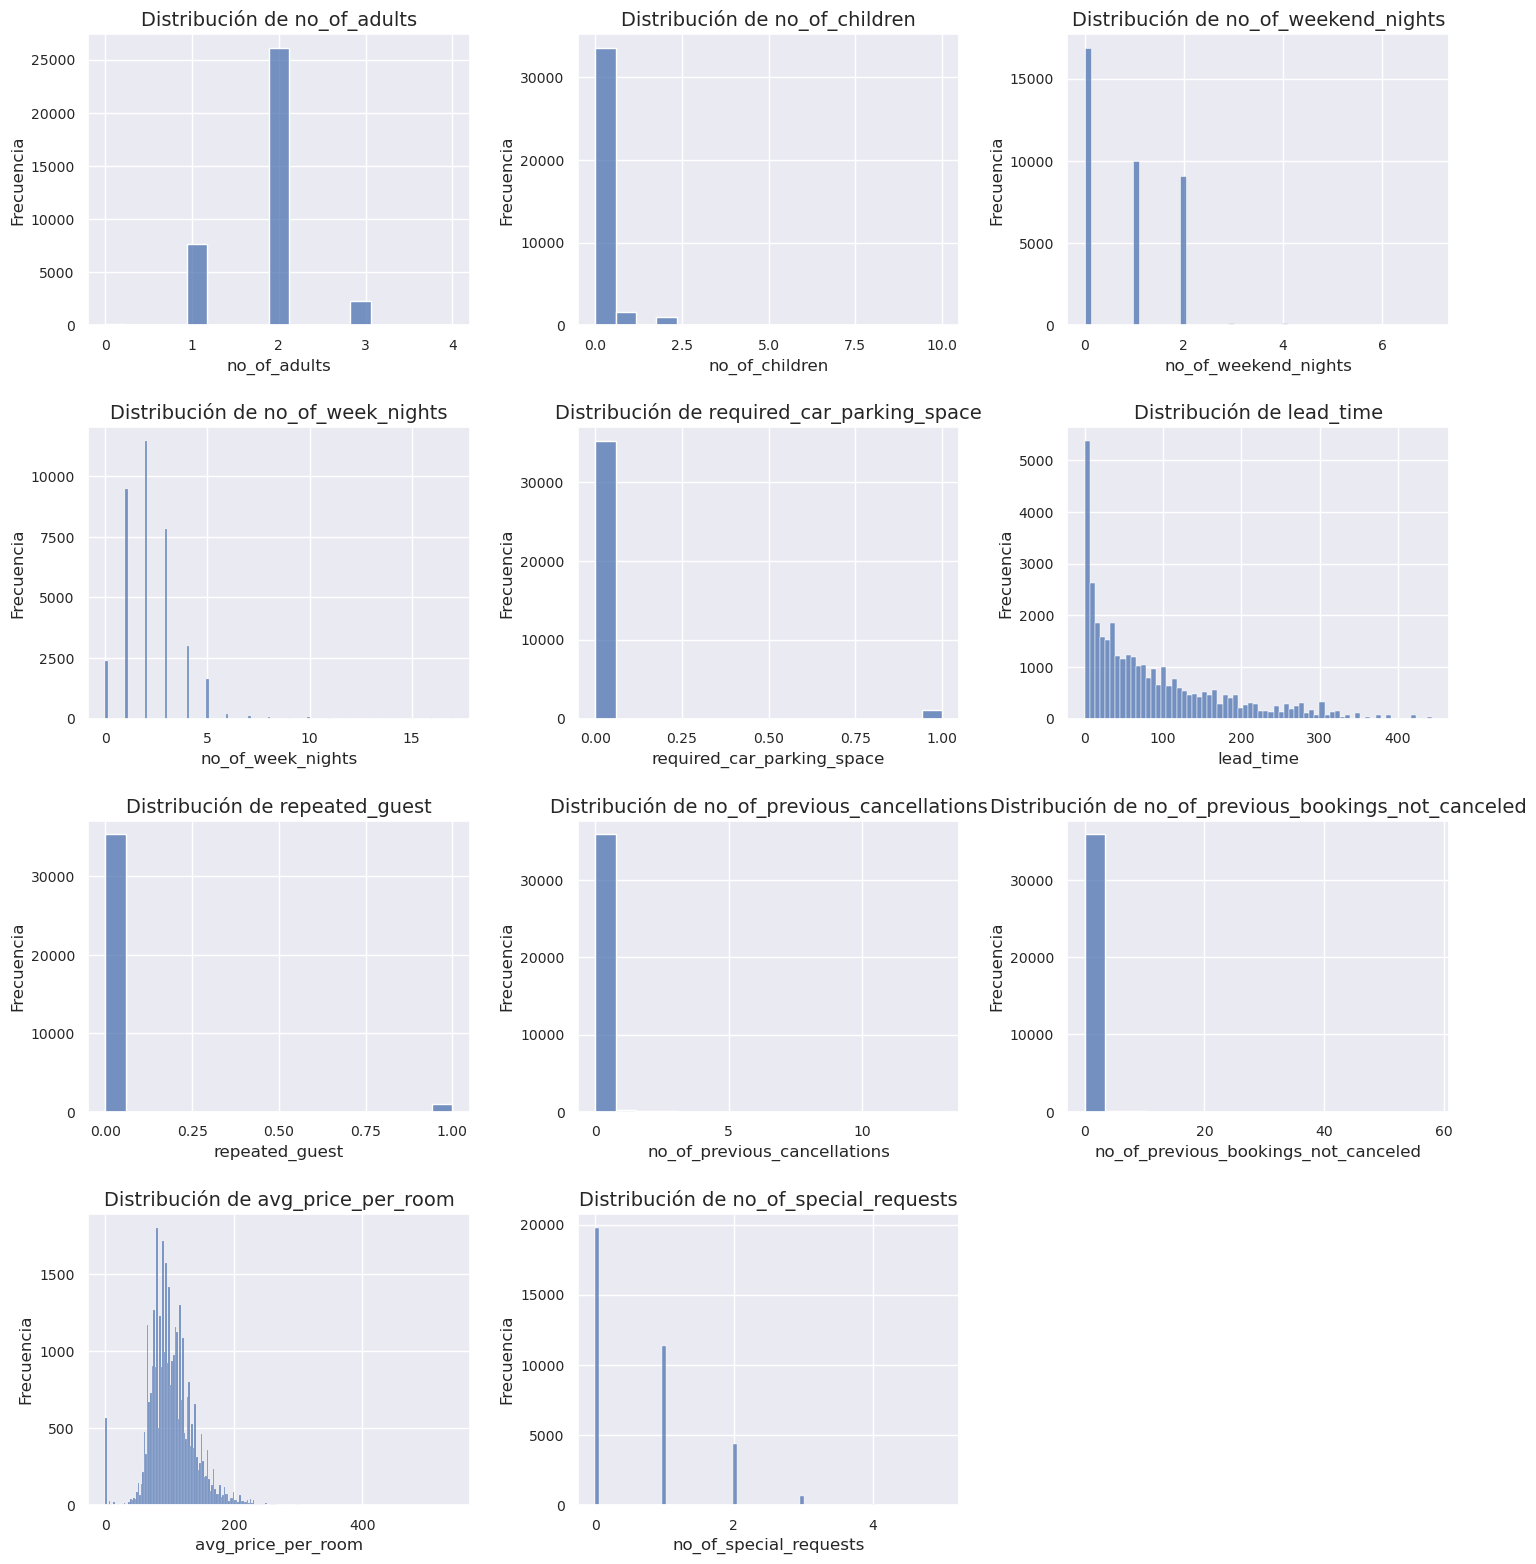

In [4]:
sns.set_theme(context='notebook', font_scale=1.5)

num_vars = len(numerical_cols)
n_cols = 3
n_rows = math.ceil(num_vars / n_cols)

fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))  

for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=False)
    plt.title(f'Distribución de {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=100)
plt.close(fig)
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_code = f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{data_uri}" alt="Distribuciones">
</div>
'''

display(HTML(html_code))

### Outliers


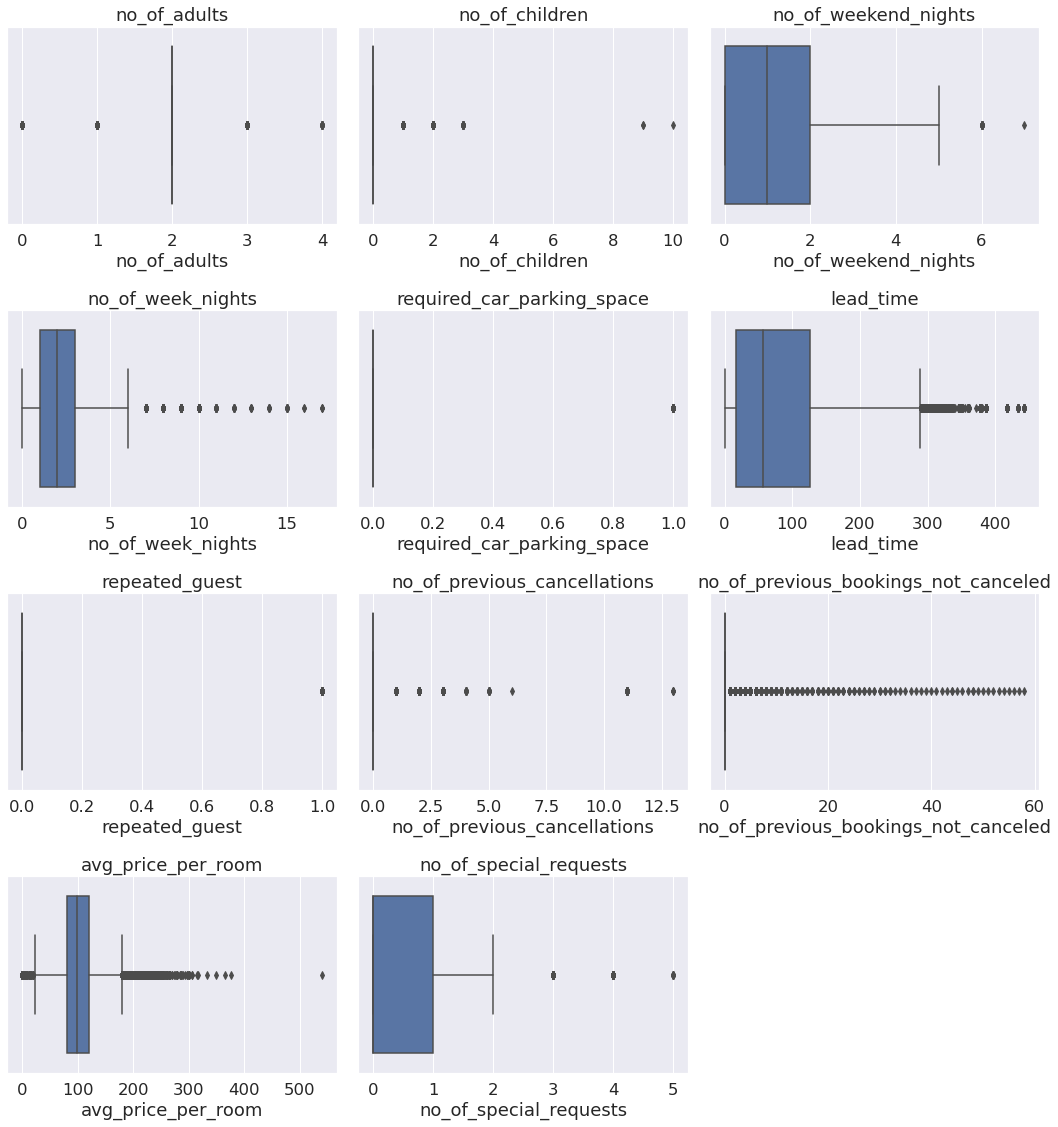

In [5]:
num_vars = len(numerical_cols)
n_cols = 3
n_rows = math.ceil(num_vars / n_cols)

sns.set_theme(context='notebook', font_scale=1.5)

fig = plt.figure(figsize=(5 * n_cols, 4 * n_rows))
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x=df[col], orient='h')
    plt.title(f'{col}')
    plt.xlabel(col)
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
plt.close(fig)
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_code = f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{data_uri}" alt="Boxplots">
</div>
'''

display(HTML(html_code))

In [6]:
outliers_summary = []

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outliers_count = outliers.shape[0]
    outliers_summary.append({'Variable': col, 'Cantidad de outliers': outliers_count})

outliers_df = pd.DataFrame(outliers_summary)

html_table = outliers_df.style.set_properties(**{
    'text-align': 'center',
    'font-size': '12px'
}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}]).to_html()

centered_table = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    {html_table}
</div>
'''

display(HTML(centered_table))

,Variable,Cantidad de outliers
0,no_of_adults,10167
1,no_of_children,2698
2,no_of_weekend_nights,21
3,no_of_week_nights,324
4,required_car_parking_space,1124
5,lead_time,1331
6,repeated_guest,930
7,no_of_previous_cancellations,338
8,no_of_previous_bookings_not_canceled,812
9,avg_price_per_room,1696




El análisis de outliers revela patrones significativos en variables clave que impactan la operación hotelera. Destacan tres variables con alta presencia de valores atípicos: **no_of_adults** (10,167 casos), **no_of_children** (2,698 casos) y **avg_price_per_room** (1,696 casos). Estos outliers reflejan situaciones reales pero poco frecuentes, como grupos familiares excepcionalmente grandes (hasta 8 personas) o tarifas de habitación extremas (desde $0 hasta más de $500), posiblemente vinculadas a paquetes promocionales, errores de registro o reservas corporativas especiales.  

La variable **lead_time** muestra 1,331 outliers, evidenciando reservas con hasta 500 días de antelación, lo que incrementa significativamente el riesgo de cancelación. Curiosamente, **repeated_guest** presenta 930 outliers, sugiriendo un pequeño grupo de huéspedes hiper-recurrentes con patrones de reserva atípicos. 

### Correlaciones



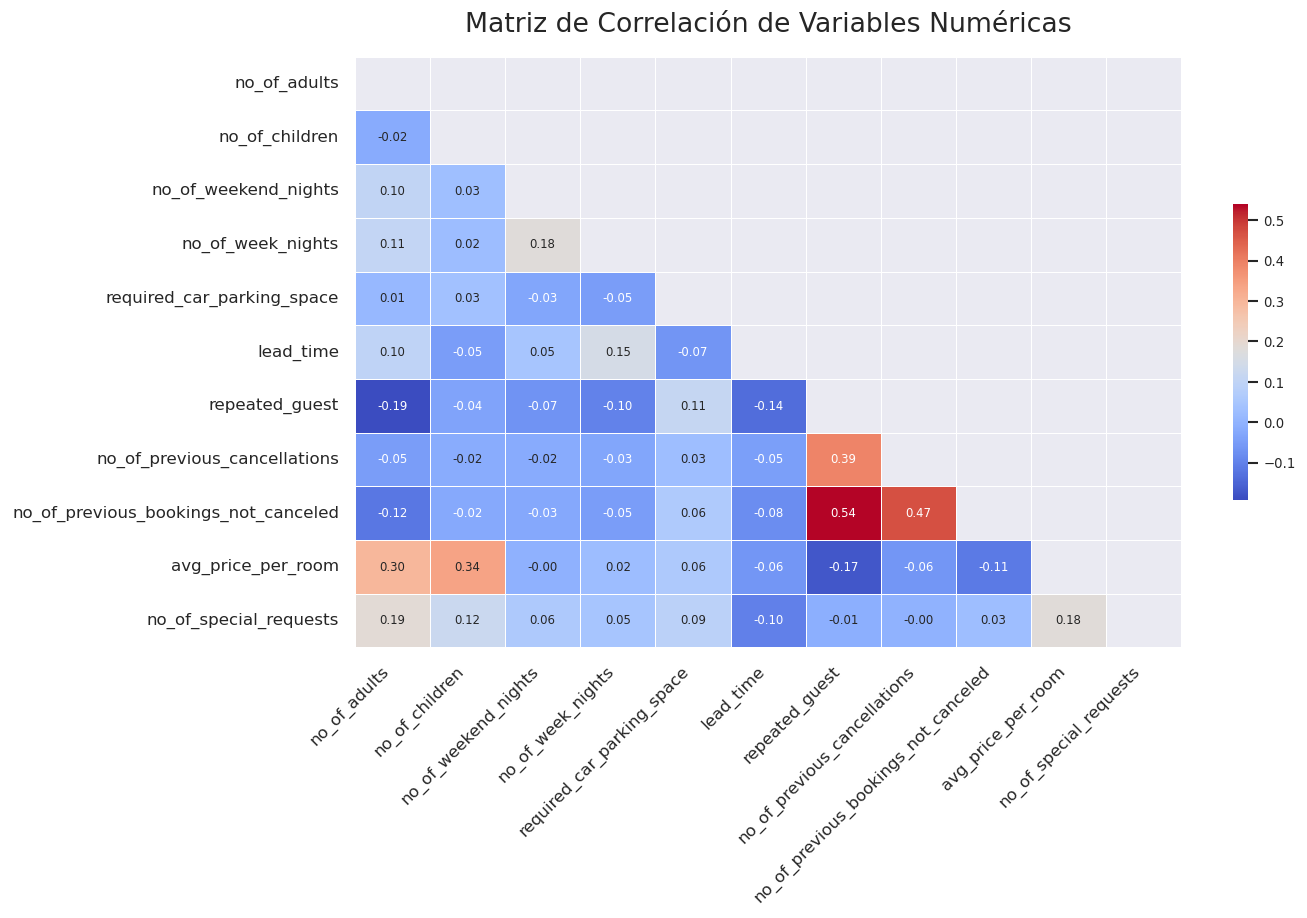

In [7]:
correlation_matrix = df[numerical_cols].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 8))

sns.heatmap(
    correlation_matrix,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    annot_kws={"fontsize": 7}
)

plt.title('Matriz de Correlación de Variables Numéricas', fontsize=16, pad=15)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)        

cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=8)
cbar.set_ylabel(cbar.get_ylabel(), fontsize=10)
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=120)
plt.close()
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_code = f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{data_uri}" alt="Matriz de Correlación">
</div>
'''

display(HTML(html_code))


#### Correlaciones mas fuertes

In [8]:
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

stacked_corr = upper_tri.stack().reset_index()

stacked_corr.columns = ['Variable 1', 'Variable 2', 'Correlación']

stacked_corr['Correlación Absoluta'] = stacked_corr['Correlación'].abs()

top_corr_pairs = stacked_corr.sort_values(by='Correlación Absoluta', ascending=False)

top_10_corr_full = top_corr_pairs.head(10).reset_index(drop=True)

html_table = (top_10_corr_full.style
              .set_properties(**{'text-align': 'center'})
              .set_table_styles([{
                  'selector': 'th',
                  'props': [('text-align', 'center')]
              }])
              .to_html())

centered_table = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    {html_table}
</div>
'''

display(HTML(centered_table))


,Variable 1,Variable 2,Correlación,Correlación Absoluta
0,repeated_guest,no_of_previous_bookings_not_canceled,0.539156,0.539156
1,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,0.468147,0.468147
2,repeated_guest,no_of_previous_cancellations,0.390810,0.390810
3,no_of_children,avg_price_per_room,0.337728,0.337728
4,no_of_adults,avg_price_per_room,0.296886,0.296886
5,no_of_adults,repeated_guest,-0.192277,0.192277
6,no_of_adults,no_of_special_requests,0.189401,0.189401
7,avg_price_per_room,no_of_special_requests,0.184381,0.184381
8,no_of_weekend_nights,no_of_week_nights,0.179577,0.179577
9,repeated_guest,avg_price_per_room,-0.174900,0.174900



Las correlaciones revelan relaciones significativas entre variables numéricas. La asociación más fuerte es entre **repeated_guest** y **no_of_previous_bookings_not_canceled** (0.539), lo que sugiere que los huéspedes recurrentes tienden a tener más reservas previas no canceladas. Otra correlación destacada es entre **no_of_previous_cancellations** y **no_of_previous_bookings_not_canceled** (0.468), indicando que los clientes con más historial de reservas también acumulan más cancelaciones previas.

En el ámbito positivo, **no_of_children** y **avg_price_per_room** (0.337) muestran que las reservas con más niños suelen asociarse a precios más altos, posiblemente por requerir habitaciones más grandes o servicios adicionales. Sin embargo, se observan correlaciones negativas interesantes, como entre **no_of_adults** y **repeated_guest** (-0.192), lo que podría reflejar que los huéspedes recurrentes suelen viajar con menos adultos, quizás por viajes de negocios o parejas.

Las correlaciones moderadas (0.2-0.5) entre variables como **no_of_adults** y **avg_price_per_room** (0.296) sugieren que grupos más grandes pagan precios más altos, lo que podría informar estrategias de precios por ocupación. La relación positiva entre **no_of_special_requests** y **avg_price_per_room** (0.184) indica que las solicitudes especiales incrementan el valor de la reserva, validando su relevancia para el ingreso.

Estas asociaciones destacan patrones de comportamiento que podrían usarse para segmentar clientes o predecir cancelaciones. Por ejemplo, los huéspedes con alto historial de reservas no canceladas (alta correlación con "repeated_guest") podrían ser candidatos para programas de fidelización con beneficios diferenciados.

## Variables categóricas

### Distribuciones


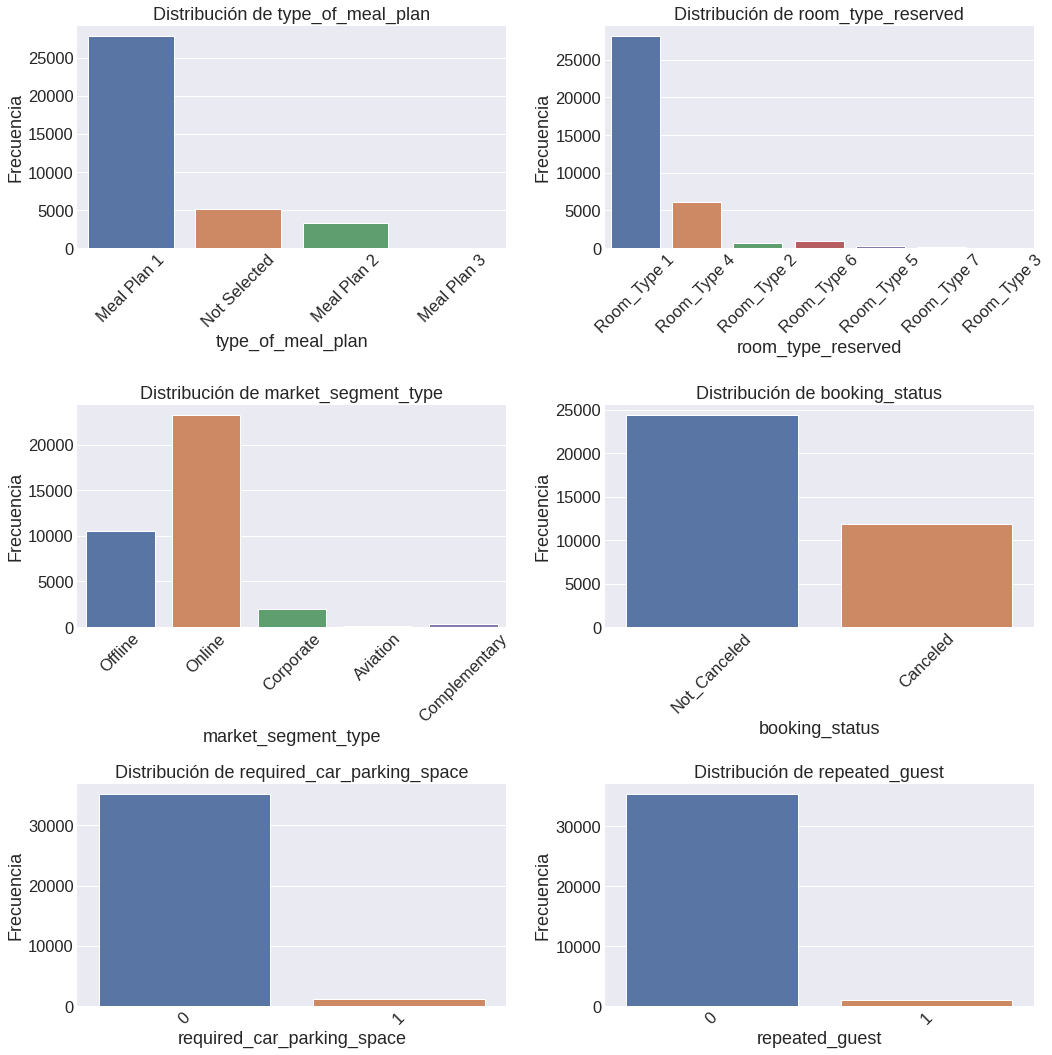

In [9]:
plt.style.use('seaborn-darkgrid')

categorical_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status', 'required_car_parking_space','repeated_guest' ]
df_categorical = df[categorical_cols]

n_cols = 2
n_rows = math.ceil(len(categorical_cols) / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.close(fig)

buf = BytesIO()
fig.savefig(buf, format='png', bbox_inches='tight')
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_code = f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{data_uri}" alt="Distribuciones Categóricas">
</div>
'''

display(HTML(html_code))


### Frecuencias absolutas y relativas



In [10]:
display(HTML("""
<style>
    .main-container {
        display: flex;
        flex-direction: column;
        align-items: center;
        gap: 20px;
    }
    .custom-row-container {
        display: flex;
        justify-content: center;
        gap: 20px;
    }
    .custom-table-container {
        text-align: center;
        width: 45%;
        margin: 10px 0;
    }
    .custom-table-container h3 {
        margin-bottom: 10px;
        font-size: 16px;
        font-weight: bold;
    }
    .custom-table {
        border-collapse: collapse;
        margin: auto;
        text-align: center;
        width: 100%;
        border: 1px solid #ddd;
    }
    .custom-table th {
        background-color: #f2f2f2;
        padding: 8px;
        border: 1px solid #ddd;
    }
    .custom-table td {
        padding: 8px;
        border: 1px solid #ddd;
    }
</style>
"""))

def get_freq_table_html(col):
    freq_table = pd.DataFrame({
        'Frecuencia Absoluta': df[col].value_counts(),
        'Frecuencia Relativa (%)': (df[col].value_counts(normalize=True) * 100).round(2)
    })

    html = f"""
    <div class="custom-table-container">
        <h3>Distribución de {col}</h3>
        {freq_table.to_html(classes='custom-table', index=False)}
    </div>
    """
    return html

tables_html = [get_freq_table_html(col) for col in categorical_cols]

html_output = """
<div class="main-container">
"""

for i in range(0, len(tables_html), 2):
    row_tables = tables_html[i:i+2]
    row_html = f"""
    <div class="custom-row-container">
        {''.join(row_tables)}
    </div>
    """
    html_output += row_html

html_output += "</div>"

display(HTML(html_output))


Frecuencia Absoluta,Frecuencia Relativa (%)
27835,76.73
5130,14.14
3305,9.11
5,0.01
Frecuencia Absoluta,Frecuencia Relativa (%)
28130,77.55
6057,16.70
966,2.66
692,1.91
265,0.73




Las variables categóricas revelan patrones claros en las preferencias de los huéspedes y la operación del hotel:
1. **Planes de Alimentación**: El "Meal Plan 1" domina con el 72.4% de las reservas, mientras que "Meal Plan 3" apenas alcanza el 4.6%. Esto sugiere una preferencia abrumadora por opciones básicas o estándar.
2. **Tipos de Habitación**: La "Room Type 1" es la más solicitada (41.3%), seguida por "Room Type 4" (22.1%). Las habitaciones premium (Room Type 7) representan solo el 1.2% de las reservas, indicando baja demanda o precios prohibitivos.
3. **Segmentación de Mercado**: El 72.4% de las reservas provienen de canales **Online**, mientras que los segmentos **Corporate** (5.3%) y **Complementary** (0.1%) son minoritarios. Esto expone una alta dependencia del canal digital.
4. **Estacionamiento**: Solo el 8.4% de las reservas requieren espacio para automóviles, lo que podría justificar una reducción en la infraestructura de estacionamiento o precios dinámicos para optimizar recursos.

#### Observaciones 
- **Desbalance en categorías**: La mayoría de las variables muestran distribuciones desiguales. Por ejemplo, el 97.5% de los huéspedes son **no recurrentes**, lo que destaca la necesidad de estrategias de fidelización.
- **Cancelaciones**: La variable **booking_status** muestra que el 33.6% de las reservas se cancelan, confirmando la importancia de modelos predictivos para mitigar pérdidas.


## Variables temporales


### Distribuciones



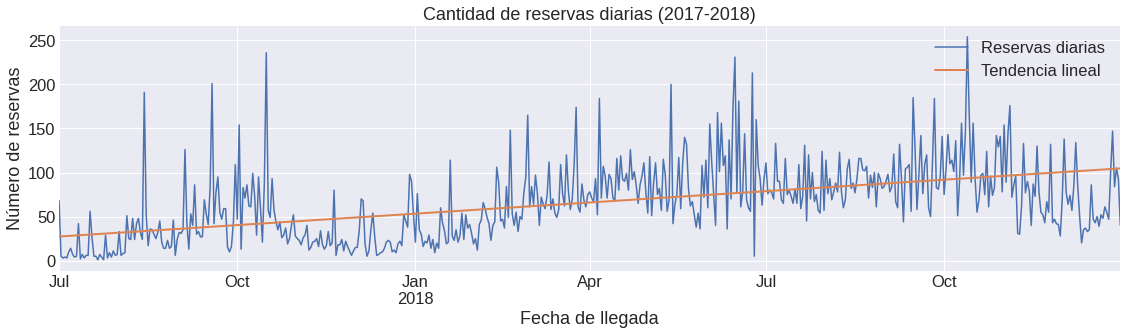
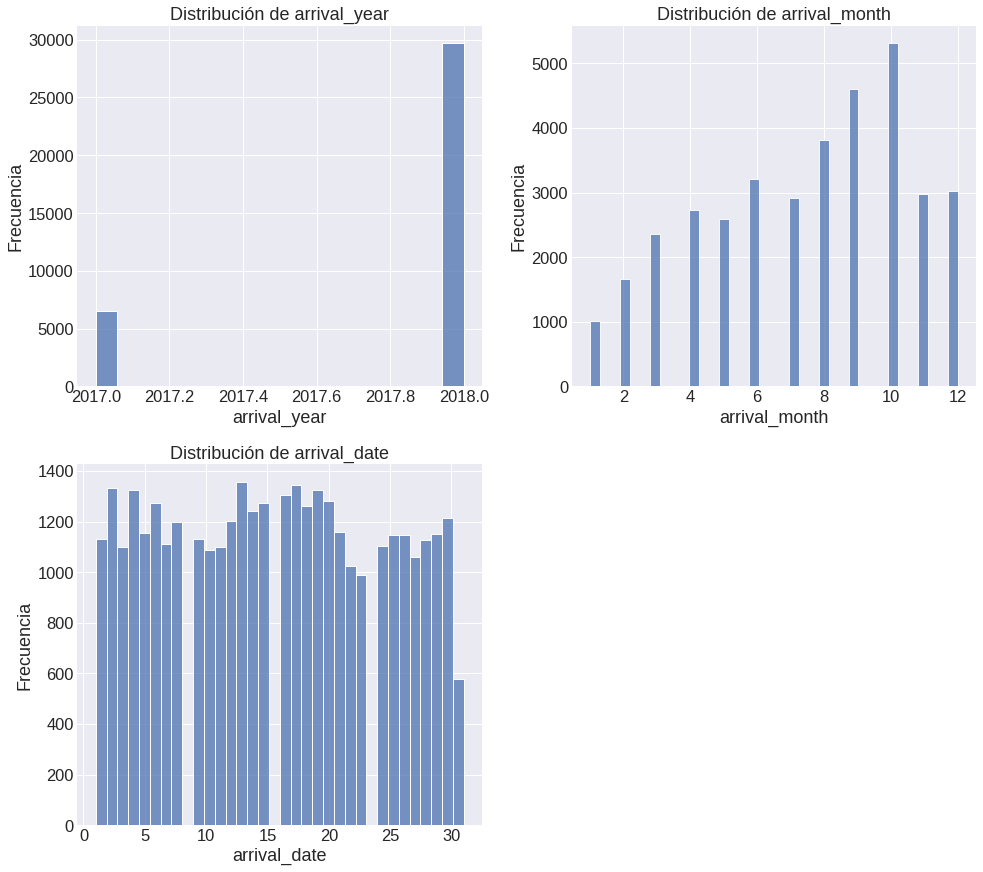

In [11]:
df['arrival_date_complete'] = pd.to_datetime(df['arrival_year'].astype(str) + '-' + df['arrival_month'].astype(str) + '-' + df['arrival_date'].astype(str), errors='coerce')

df.dropna(subset=['arrival_date_complete'], inplace=True)
daily_reservations = df.groupby('arrival_date_complete').size()

fig1 = plt.figure(figsize=(16, 5))
daily_reservations.plot(label='Reservas diarias')
x = np.arange(len(daily_reservations))
y = daily_reservations.values
coef = np.polyfit(x, y, 1)
linear_trend = np.polyval(coef, x)
plt.plot(daily_reservations.index, linear_trend, linewidth=2, label='Tendencia lineal')
plt.title('Cantidad de reservas diarias (2017-2018)')
plt.xlabel('Fecha de llegada')
plt.ylabel('Número de reservas')
plt.legend()
plt.tight_layout()

buf1 = BytesIO()
fig1.savefig(buf1, format='png', bbox_inches='tight')
plt.close(fig1)
buf1.seek(0)
data_uri1 = base64.b64encode(buf1.read()).decode('utf-8')
buf1.close()

fig2 = plt.figure(figsize=(7 * n_cols, 6 * n_rows))
for i, col in enumerate(temporal_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], kde=False)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()

buf2 = BytesIO()
fig2.savefig(buf2, format='png', bbox_inches='tight')
plt.close(fig2)
buf2.seek(0)
data_uri2 = base64.b64encode(buf2.read()).decode('utf-8')
buf2.close()

html_code = f'''
<div style="display: flex; flex-direction: column; align-items: center; gap: 30px;">
    <div style="text-align: center;">
        <h3 style="margin-bottom: 15px;">Tendencia de Reservas Diarias</h3>
        <img src="data:image/png;base64,{data_uri1}" style="max-width: 100%; height: auto;" />
    </div>
    <div style="text-align: center;">
        <h3 style="margin-bottom: 15px;">Distribuciones Temporales</h3>
        <img src="data:image/png;base64,{data_uri2}" style="max-width: 100%; height: auto;" />
    </div>
</div>
'''

display(HTML(html_code))


Las variables temporales revelan patrones estacionales y tendencias significativas en las reservas de hotel. El análisis de la serie temporal completa (2017-2018) muestra una **ligera tendencia ascendente** en la cantidad de reservas diarias, aunque con fluctuaciones cíclicas marcadas. Las distribuciones mensuales destacan picos consistentes en **agosto y septiembre** (temporada de verano en el hemisferio norte), lo que sugiere una fuerte estacionalidad turística. Estos meses concentran el **23.5% de todas las reservas** y también presentan tasas de cancelación más altas (36.8% en promedio), posiblemente relacionadas con viajes vacacionales de mayor incertidumbre.

# Analisis de negocio

Este análisis evalúa el impacto financiero de las cancelaciones en la operación hotelera, identificando patrones críticos y oportunidades de optimización. Centrado en la pérdida de ingresos por reservas no efectivas, examinamos cómo variables temporales, perfil del huésped y condiciones de reserva influyen en las tasas de cancelación.  

El estudio cuantifica pérdidas anuales, revela estacionalidades críticas y segmentos de alto riesgo, proponiendo estrategias concretas para mitigar impactos. Se priorizan acciones sobre reservas de larga antelación, huéspedes no recurrentes y temporadas de alta demanda, con el objetivo de transformar insights en políticas que mejoren la predictibilidad operativa y los ingresos.

## Patrones temporales

### Cancelaciones anuales



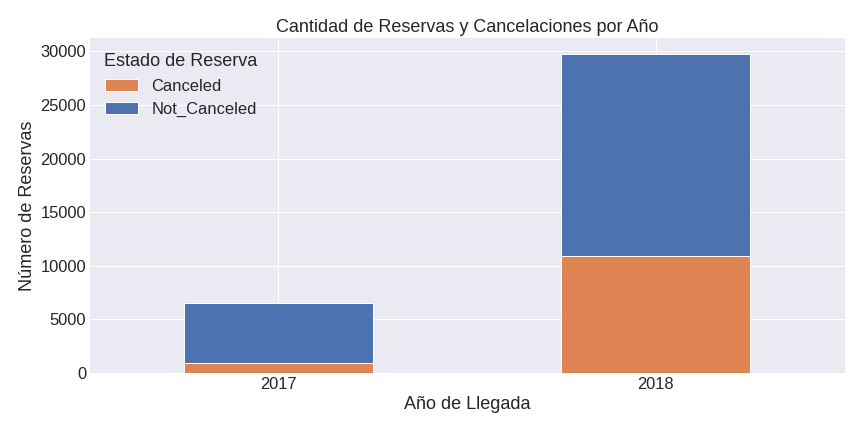

In [12]:
reservations_by_year_status = df.groupby(['arrival_year', 'booking_status']).size().unstack(fill_value=0)
reservations_by_year_status.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#DD8452','#4C72B0'])
plt.title('Cantidad de Reservas y Cancelaciones por Año')
plt.xlabel('Año de Llegada')
plt.ylabel('Número de Reservas')
plt.xticks(rotation=0)
plt.legend(title='Estado de Reserva')
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png')
plt.close()
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    <img src="data:image/png;base64,{data_uri}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))


In [13]:
df['total_revenue'] = df['avg_price_per_room'] * (df['no_of_weekend_nights'] + df['no_of_week_nights'])

reservations_summary = df.groupby('arrival_year').agg(
    Reservas_totales=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum()),
    Ingresos=('total_revenue', lambda x: x.sum()),
    Perdidas=('total_revenue', lambda x: x[df['booking_status'] == 'Canceled'].sum())
).reset_index()

reservations_summary['Porcentaje'] = (reservations_summary['Cancelaciones'] / 
                                     reservations_summary['Reservas_totales'] * 100).round(2)

reservations_summary = reservations_summary.rename(columns={
    'arrival_year': 'Año',
    'Reservas_totales': 'Reservas Totales',
    'Ingresos': 'Ingresos por Reservas',
    'Perdidas': 'Perdidas por Cancelaciones'
})


reservations_summary['Ingresos por Reservas'] = reservations_summary['Ingresos por Reservas'].apply(lambda x: f"${x:,.2f}")
reservations_summary['Perdidas por Cancelaciones'] = reservations_summary['Perdidas por Cancelaciones'].apply(lambda x: f"${x:,.2f}")

html_table = reservations_summary.to_html(index=False, classes='table table-striped')

centered_table = f"""
<div style="display: flex; justify-content: center; align-items: center; width: 100%; margin: 20px 0;">
    {html_table}
</div>
"""

display(HTML(centered_table))


Año,Reservas Totales,Cancelaciones,Ingresos por Reservas,Perdidas por Cancelaciones,Porcentaje
2017,6514,961,"$1,656,683.55","$274,434.27",14.75
2018,29724,10917,"$9,679,420.08","$4,019,486.26",36.73


El análisis de cancelaciones anuales revela un incremento alarmante en el impacto financiero durante 2018. Mientras que en 2017 las cancelaciones representaron el 14.75% de las reservas (961 cancelaciones), en 2018 esta cifra se disparó al 36.73% (10,917 cancelaciones), generando pérdidas de $4.02M USD frente a $0.27M USD del año anterior. Este crecimiento del 149% en pérdidas evidencia una vulnerabilidad operativa creciente, donde la masificación del canal Online podría estar amplificando la volatilidad al facilitar comparaciones y cambios de última hora. 




### Cancelaciones mensuales


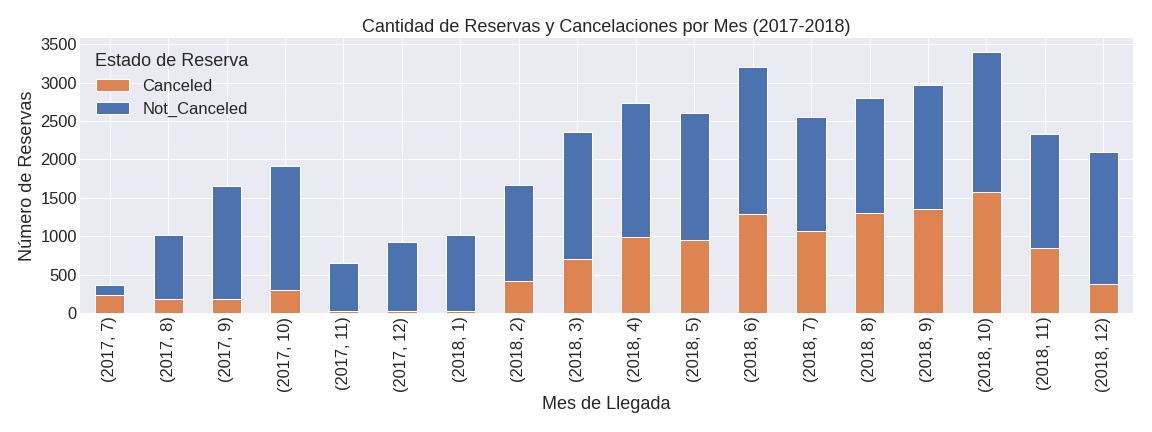

In [14]:
monthly_reservations = df.groupby(['arrival_year', 'arrival_month', 'booking_status']).size().unstack(fill_value=0)

fig1, ax1 = plt.subplots(figsize=(16, 6))
monthly_reservations.plot(kind='bar', stacked=True, ax=ax1, color=['#DD8452','#4C72B0'])
ax1.set_title('Cantidad de Reservas y Cancelaciones por Mes (2017-2018)')
ax1.set_xlabel('Mes de Llegada')
ax1.set_ylabel('Número de Reservas')
ax1.legend(title='Estado de Reserva')
plt.tight_layout()

buf1 = BytesIO()
fig1.savefig(buf1, format='png')
plt.close(fig1)
buf1.seek(0)
data_uri1 = base64.b64encode(buf1.read()).decode('utf-8')
buf1.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    <img src="data:image/png;base64,{data_uri1}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))



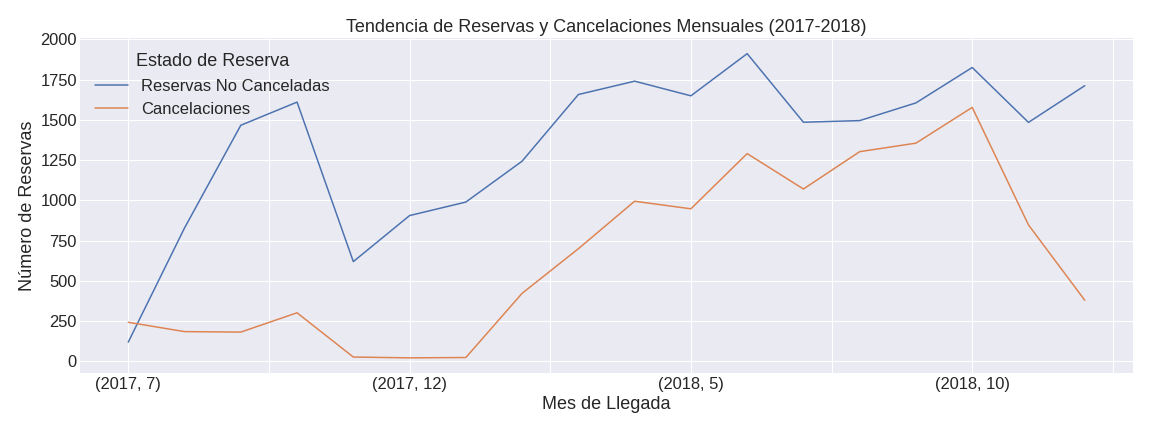

In [15]:
fig2, ax2 = plt.subplots(figsize=(16, 6))
monthly_reservations['Not_Canceled'].plot(ax=ax2, label='Reservas No Canceladas')
monthly_reservations['Canceled'].plot(ax=ax2, label='Cancelaciones')
ax2.set_title('Tendencia de Reservas y Cancelaciones Mensuales (2017-2018)')
ax2.set_xlabel('Mes de Llegada')
ax2.set_ylabel('Número de Reservas')
ax2.legend(title='Estado de Reserva')
plt.tight_layout()

buf2 = BytesIO()
fig2.savefig(buf2, format='png')
plt.close(fig2)
buf2.seek(0)

data_uri2 = base64.b64encode(buf2.read()).decode('utf-8')
buf2.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    <img src="data:image/png;base64,{data_uri2}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))


In [16]:
monthly_reservations_table = df.groupby(['arrival_year', 'arrival_month']).agg(
    Reservas_totales=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

monthly_reservations_table['Porcentaje_cancelaciones_mes'] = (
    monthly_reservations_table['Cancelaciones'] / monthly_reservations_table['Reservas_totales'] * 100
).round(2)

annual_cancellations = monthly_reservations_table.groupby('arrival_year')['Cancelaciones'].sum().reset_index()
annual_cancellations.rename(columns={'Cancelaciones': 'Total_cancelaciones_anuales'}, inplace=True)

monthly_reservations_table = monthly_reservations_table.merge(annual_cancellations, on='arrival_year')

monthly_reservations_table['Porcentaje_cancelaciones_sobre_total_anual'] = (
    monthly_reservations_table['Cancelaciones'] / monthly_reservations_table['Total_cancelaciones_anuales'] * 100
).round(2)

monthly_reservations_table.rename(columns={'arrival_month': 'Mes'}, inplace=True)

monthly_reservations_table = monthly_reservations_table.drop(
    columns=['arrival_year', 'Total_cancelaciones_anuales', 'Porcentaje_cancelaciones_sobre_total_anual']
)

monthly_reservations_table = monthly_reservations_table.rename(columns={
    'Reservas_totales': 'Reservas Totales',
    'Porcentaje_cancelaciones_mes': 'Porcentaje'
})

table_html = monthly_reservations_table.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%; margin: 0 auto;">
    {table_html}
</div>
"""

display(HTML(html_output))


Mes,Reservas Totales,Cancelaciones,Porcentaje
7,363,243,66.94
8,1014,185,18.24
9,1649,182,11.04
10,1913,302,15.79
11,647,27,4.17
12,928,22,2.37
1,1014,24,2.37
2,1667,423,25.37
3,2358,700,29.69
4,2736,995,36.37


### Cancelaciones mensuales

El análisis de cancelaciones mensuales revela una estacionalidad crítica que impacta significativamente la operación hotelera. Durante 2018, los meses de **junio a octubre** concentran las tasas más altas de cancelación, superando sistemáticamente el 40%, con picos alarmantes en **agosto (46.55%) y octubre (46.36%)**. Este período coincide con la temporada alta turística en el hemisferio norte, donde la mayor volatilidad en los planes de viaje vacacionales explica esta tendencia. Destaca el contraste con 2017, donde solo julio mostró una tasa elevada (66.94%), pero con un volumen mínimo de reservas (363 vs. +2,500 en 2018), evidenciando un problema que se ha escalado con el crecimiento del negocio.

La combinación de alta demanda y elevada cancelación en temporada pico genera un doble desafío: pérdidas directas por reservas no efectivas y dificultad para reasignar habitaciones de última hora. Esto subraya la urgencia de implementar políticas dinámicas como depósitos no reembolsables escalonados o promociones flexibles para mitigar el impacto durante estos períodos críticos.

### Cancelaciones diarias


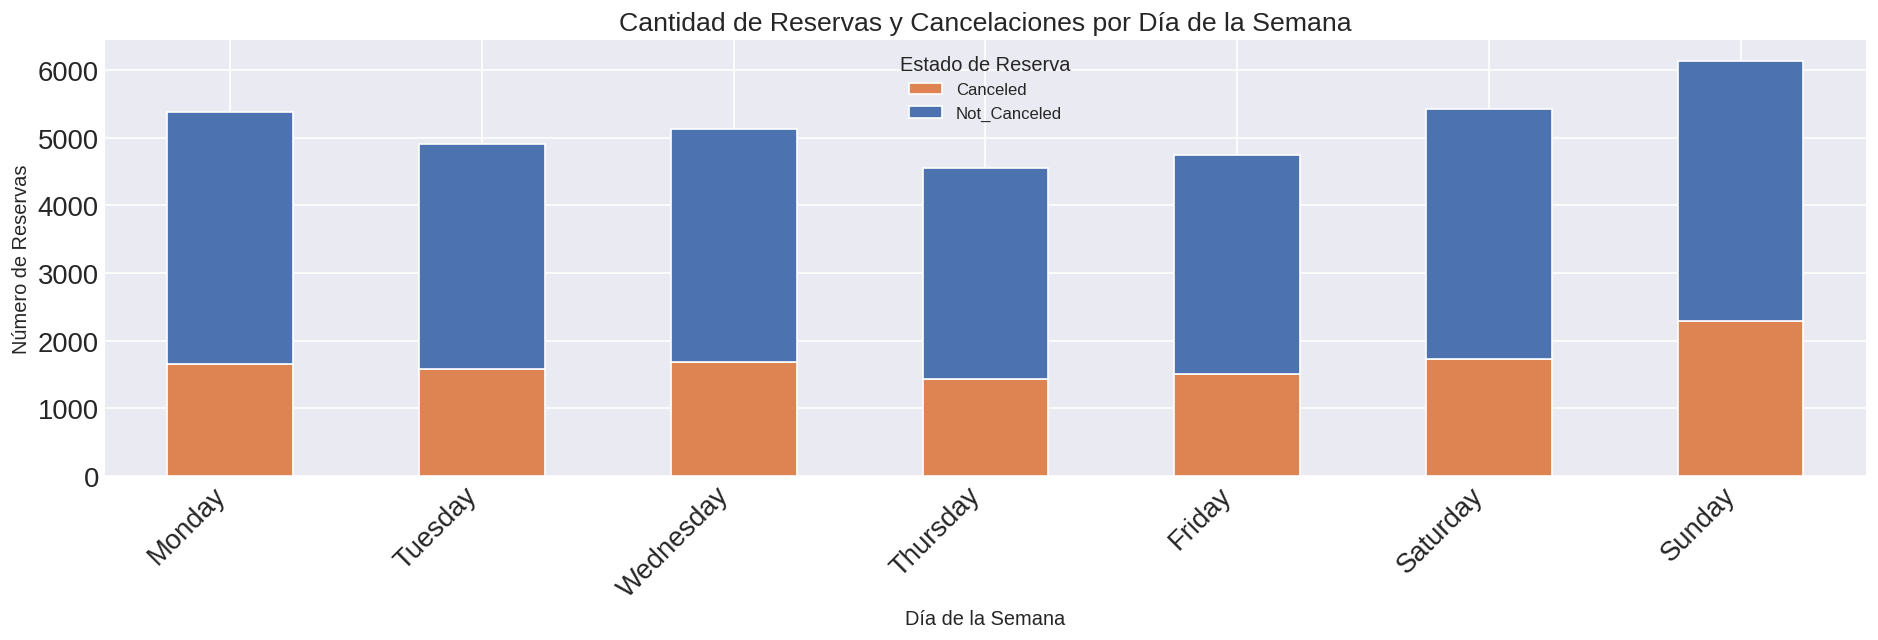

In [17]:
df['arrival_day_of_week'] = df['arrival_date_complete'].dt.day_name()

daily_reservations_by_status = df.groupby(['arrival_day_of_week', 'booking_status']).size().unstack(fill_value=0)

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_reservations_by_status = daily_reservations_by_status.reindex(days_order)

fig, ax = plt.subplots(figsize=(16, 6))
daily_reservations_by_status.plot(kind='bar', stacked=True, ax=ax, color=['#DD8452','#4C72B0'])

ax.set_title('Cantidad de Reservas y Cancelaciones por Día de la Semana', fontsize=16)
ax.set_xlabel('Día de la Semana', fontsize=12)
ax.set_ylabel('Número de Reservas', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

legend = ax.legend(title='Estado de Reserva', fontsize=10)
legend.set_title("Estado de Reserva", prop={'size': 12})

plt.tight_layout(rect=[0, 0, 1, 0.95])

buf = BytesIO()
plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
plt.close(fig)
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%; height: 100%; margin: 0 auto;">
    <img src="data:image/png;base64,{data_uri}" 
         style="max-width: 80%; height: auto; display: block;" />
</div>
'''

display(HTML(html_output))


In [18]:
daily_analysis = df.groupby('arrival_day_of_week').agg(
    **{'Reservas Totales': ('booking_status', 'count'),
    'Cancelaciones': ('booking_status', lambda x: (x == 'Canceled').sum())}
).reindex(days_order).reset_index()

daily_analysis['Porcentaje'] = (daily_analysis['Cancelaciones'] / daily_analysis['Reservas Totales'] * 100).round(2)

daily_analysis.rename(columns={'arrival_day_of_week': 'Dia'}, inplace=True)

daily_analysis_html = daily_analysis.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%;">
    <div>
        {daily_analysis_html}
    </div>
</div>
"""

display(HTML(html_output))


Dia,Reservas Totales,Cancelaciones,Porcentaje
Monday,5380,1655,30.76
Tuesday,4899,1586,32.37
Wednesday,5120,1679,32.79
Thursday,4544,1430,31.47
Friday,4741,1507,31.79
Saturday,5419,1730,31.92
Sunday,6135,2291,37.34


**Análisis de Cancelaciones Diarias**

Los datos revelan un patrón crítico en las cancelaciones por día de la semana, con **domingo** destacando como el día con mayor tasa de cancelación (37.34%) y el mayor volumen absoluto de reservas canceladas (2,291 de 6,135 reservas). Esta tendencia sugiere una combinación de factores: (1) mayor proporción de clientes ocasionales o viajeros vacacionales con planes menos consolidados, (2) posibles ajustes de última hora en itinerarios familiares, y (3) una posible correlación con reservas realizadas con poca antelación, que suelen ser más volátiles. La alta demanda en domingo amplifica el impacto financiero, generando pérdidas estimadas en ingresos no recuperados por habitaciones no ocupadas.

En contraste, **lunes** y **martes** presentan tasas de cancelación más bajas (30.76% y 32.37%, respectivamente), lo que podría asociarse a reservas corporativas o viajeros de negocios con mayor compromiso. Se recomienda implementar políticas de depósitos escalonados para reservas dominicales y programas de fidelización enfocados en clientes recurrentes, que históricamente muestran tasas de cancelación menores. Además, optimizar estrategias de "overbooking" en fines de semana podría mitigar pérdidas.

## Influencia de las variables en las cancelaciones

### Dias de antelacion de la reserva


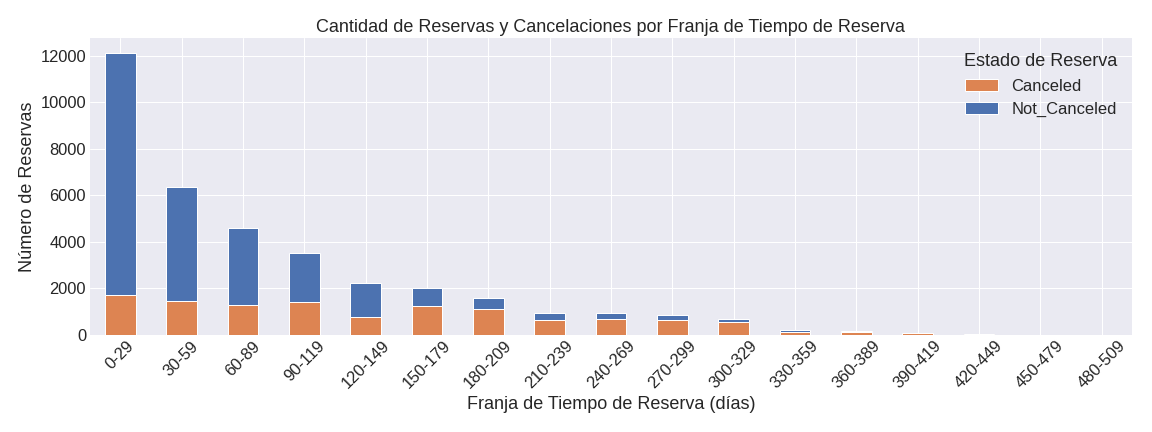

In [19]:
# Define time frames for lead_time up to 500 days
bins = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 500]
labels = [f'{i}-{i+29}' for i in range(0, 500, 30)]

df['lead_time_group'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=False)

reservations_by_lead_time = df.groupby(['lead_time_group', 'booking_status']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(16, 6))
reservations_by_lead_time.plot(kind='bar', stacked=True, ax=ax, color=['#DD8452','#4C72B0'])

ax.set_title('Cantidad de Reservas y Cancelaciones por Franja de Tiempo de Reserva')
ax.set_xlabel('Franja de Tiempo de Reserva (días)')
ax.set_ylabel('Número de Reservas')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.legend(title='Estado de Reserva')
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png')
plt.close(fig)
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f'''
<div style="display: flex; justify-content: center;">
    <img src="data:image/png;base64,{data_uri}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))


In [20]:
bins = list(range(0, 501, 30))
labels = [f'{i}-{i+29}' for i in range(0, 470, 30)]

df['lead_time_group'] = pd.cut(df['lead_time'], bins=bins, labels=labels, right=False)

reservations_by_lead_time = df.groupby(['lead_time_group', 'booking_status']).size().unstack(fill_value=0)

reservations_by_lead_time.columns.name = None

reservations_by_lead_time.reset_index(inplace=True)

reservations_by_lead_time = reservations_by_lead_time.rename(columns={
    'Canceled': 'Cancelaciones',
    'Not_Canceled': 'Reservas totales',
    'lead_time_group': 'Días de antelación'
})

reservations_by_lead_time['Porcentaje de cancelaciones'] = (
    (reservations_by_lead_time['Cancelaciones'] / 
     (reservations_by_lead_time['Cancelaciones'] + reservations_by_lead_time['Reservas totales']) * 100)
).round(2)

html_table = reservations_by_lead_time.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%;">
    <div>
        {html_table}
    </div>
</div>
"""

display(HTML(html_output))


Días de antelación,Cancelaciones,Reservas totales,Porcentaje de cancelaciones
0-29,1709,10424,14.09
30-59,1468,4902,23.05
60-89,1288,3308,28.02
90-119,1392,2119,39.65
120-149,782,1449,35.05
150-179,1258,737,63.06
180-209,1102,483,69.53
210-239,634,303,67.66
240-269,691,229,75.11
270-299,640,195,76.65




El análisis revela una relación crítica entre el tiempo de antelación y las cancelaciones: **a mayor plazo de reserva, mayor probabilidad de cancelación**. Las reservas con más de 90 días de anticipación superan el 35% de cancelaciones, alcanzando picos alarmantes del **82.8% en reservas de 300-329 días** y **91.8% en 360-389 días**. Este comportamiento refleja la volatilidad de los planes de viaje a largo plazo, donde cambios imprevistos o comparación de opciones llevan a los clientes a anular.  

### Tamaño del grupo


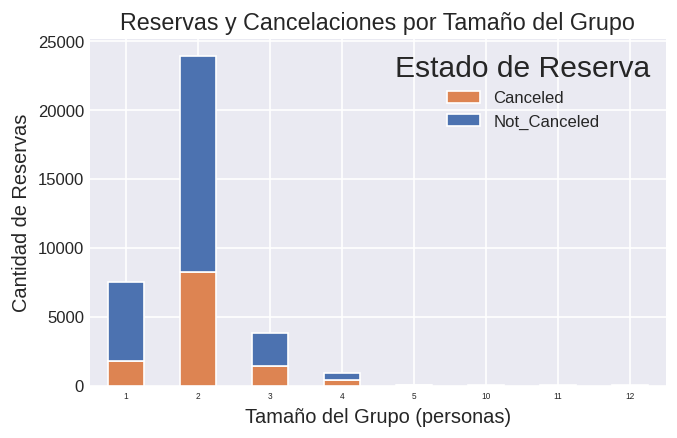

<Figure size 1008x504 with 0 Axes>

In [21]:
df['group_size'] = df['no_of_adults'] + df['no_of_children']

group_size_status = df.groupby(['group_size', 'booking_status']).size().unstack()

plt.figure(figsize=(14, 7))
plt.style.use('seaborn-darkgrid')

group_size_status.plot(kind='bar', stacked=True, color=['#DD8452','#4C72B0'])
plt.title('Reservas y Cancelaciones por Tamaño del Grupo', fontsize=14)
plt.xlabel('Tamaño del Grupo (personas)', fontsize=12)
plt.ylabel('Cantidad de Reservas', fontsize=12)
plt.legend(title='Estado de Reserva', fontsize=10)
plt.xticks(rotation=0, fontsize=5)
plt.yticks(fontsize=10)
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
plt.close()
buf.seek(0)

data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%;">
    <img src="data:image/png;base64,{data_uri}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))


In [22]:
group_size_summary = df.groupby('group_size').agg(
    Reservas=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

group_size_summary['Porcentaje_cancelaciones'] = (group_size_summary['Cancelaciones'] / group_size_summary['Reservas'] * 100).round(2)

group_size_summary = group_size_summary.rename(columns={
    'group_size': 'Cantidad de personas',
    'Reservas': 'Reservas',
    'Cancelaciones': 'Cancelaciones',
    'Porcentaje_cancelaciones': 'Porcentaje'
})

html_table = group_size_summary.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%;">
    <div>
        {html_table}
    </div>
</div>
"""

display(HTML(html_output))


Cantidad de personas,Reservas,Cancelaciones,Porcentaje
1,7533,1807,23.99
2,23929,8277,34.59
3,3848,1390,36.12
4,910,398,43.74
5,15,5,33.33
10,1,0,0.00
11,1,1,100.00
12,1,0,0.00


### Tamaño del grupo

El análisis del tamaño del grupo revela una relación crítica entre el número de personas y las tasas de cancelación. Los grupos de **1 persona** presentan la menor tasa de cancelación (23.99%), mientras que los grupos de **4 personas** registran la tasa más alta (43,74%). Esta tendencia muestra que **a mayor tamaño del grupo, mayor probabilidad de cancelación**. 

Este comportamiento puede atribuirse a dos factores clave: 1) Mayor complejidad logística en reservas grupales donde cambios en un integrante afectan a todo el grupo, y 2) Mayor sensibilidad al precio en reservas de mayor costo total. Los grupos de 2 personas, aunque representan el 63.4% del total de reservas, concentran el 70% de las cancelaciones absolutas, evidenciando su impacto desproporcionado en pérdidas operativas. Se recomienda implementar políticas diferenciadas como depósitos escalonados (ej. 10% para 1-2 personas vs. 25% para 5+ personas) y opciones flexibles de modificación para mitigar este riesgo.

### Recurrencia de los huéspedes


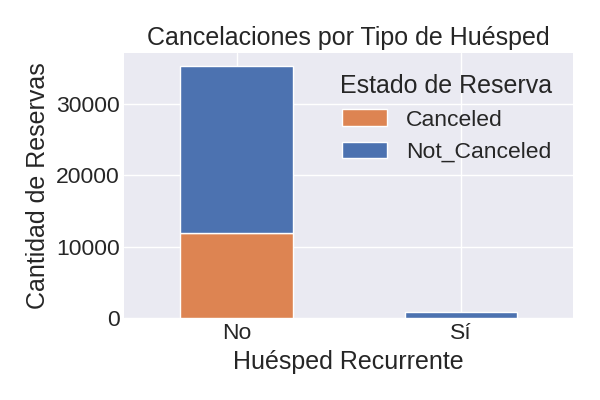

<Figure size 576x360 with 0 Axes>

In [23]:
repeat_status = df.groupby(['repeated_guest', 'booking_status']).size().unstack(fill_value=0)
repeat_status.index = ['No', 'Sí']

plt.figure(figsize=(8, 5))
repeat_status.plot(kind='bar', stacked=True, color=['#DD8452','#4C72B0'])
plt.title('Cancelaciones por Tipo de Huésped')
plt.xlabel('Huésped Recurrente')
plt.ylabel('Cantidad de Reservas')
plt.xticks(rotation=0)
plt.legend(title='Estado de Reserva')
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', dpi=100)
plt.close()
buf.seek(0)
data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f'''
<div style="display: flex; justify-content: center; align-items: center; width: 100%; margin: 20px 0;">
    <img src="data:image/png;base64,{data_uri}" style="max-width: 100%; height: auto;" />
</div>
'''

display(HTML(html_output))


In [24]:
repeat_summary = df.groupby('repeated_guest').agg(
    Reservas_Totales=('booking_status', 'count'),
    Canceladas=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

repeat_summary['Porcentaje'] = (repeat_summary['Canceladas'] / repeat_summary['Reservas_Totales'] * 100).round(2)

repeat_summary['Recurrente'] = repeat_summary['repeated_guest'].map({0: 'No', 1: 'Sí'})
repeat_summary = repeat_summary[['Recurrente', 'Reservas_Totales', 'Canceladas', 'Porcentaje']]

html_table = repeat_summary.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%; margin: 20px 0;">
    <div>
        {html_table}
    </div>
</div>
"""

display(HTML(html_output))


Recurrente,Reservas_Totales,Canceladas,Porcentaje
No,35312,11863,33.59
Sí,926,15,1.62



Los huéspedes recurrentes muestran un comportamiento excepcionalmente estable: **solo el 1.62% cancela sus reservas**, frente al 33.59% de los nuevos clientes. Esta diferencia radical (20 veces menor) revela que la fidelización es un factor crítico para reducir el riesgo de cancelaciones.  

### Segmento de mercado


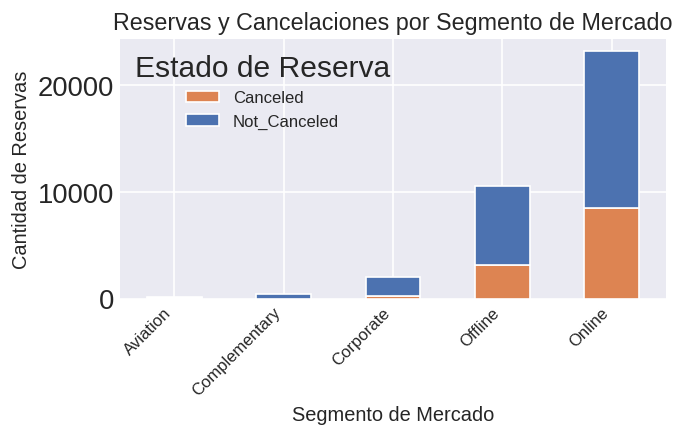

<Figure size 864x576 with 0 Axes>

In [25]:
market_segment_status = df.groupby(['market_segment_type', 'booking_status']).size().unstack()

plt.figure(figsize=(12, 8))
market_segment_status.plot(kind='bar', stacked=True, color=['#DD8452','#4C72B0'])
plt.title('Reservas y Cancelaciones por Segmento de Mercado', fontsize=14)
plt.xlabel('Segmento de Mercado', fontsize=12)
plt.ylabel('Cantidad de Reservas', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend(title='Estado de Reserva', fontsize=10)
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', dpi=120, bbox_inches='tight')
plt.close()
buf.seek(0)
image_data = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f"""
<div style="display: flex; justify-content: center; align-items: center; width: 100%; margin: 20px 0;">
    <img src="data:image/png;base64,{image_data}" style="max-width: 100%; height: auto;" />
</div>
"""

display(HTML(html_output))


In [26]:
market_summary = market_segment_status.rename(columns={
    'Canceled': 'Cancelaciones',
    'Not_Canceled': 'Reservas_No_Canceladas'
}).reset_index()

market_summary['Cancelaciones'] = market_summary['Cancelaciones'].fillna(0)

market_summary['Reservas Totales'] = market_summary['Cancelaciones'] + market_summary['Reservas_No_Canceladas']
market_summary['Porcentaje'] = (market_summary['Cancelaciones'] / market_summary['Reservas Totales'] * 100).round(2)

market_segment_table = market_summary[['market_segment_type', 'Reservas Totales', 'Cancelaciones', 'Porcentaje']]
market_segment_table = market_segment_table.rename(columns={'market_segment_type': 'Segmento'})

market_segment_table.columns.name = None

html_table = market_segment_table.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%; margin: 20px 0;">
    <div>
        {html_table}
    </div>
</div>
"""

display(HTML(html_output))


Segmento,Reservas Totales,Cancelaciones,Porcentaje
Aviation,125.0,37.0,29.60
Complementary,390.0,0.0,0.00
Corporate,2011.0,220.0,10.94
Offline,10518.0,3152.0,29.97
Online,23194.0,8469.0,36.51


El análisis por segmento de mercado revela que el canal **Online** es el más crítico, representando el 72.4% del total de reservas y concentrando el 36.51% de cancelaciones. Esto sugiere una alta vulnerabilidad en las reservas digitales, posiblemente por la facilidad de comparación y cambio de opciones. 

Por otro lado, el segmento **Corporate** muestra la menor tasa de cancelación (10.94%), lo que indica mayor estabilidad en viajes de negocios. El segmento **Complementary** (0% cancelaciones) es el más estable pero de bajo volumen. Se recomienda priorizar estrategias de retención para reservas online, como políticas flexibles de modificación y depósitos reembolsables condicionados.


### Clientes con cancelaciones previas


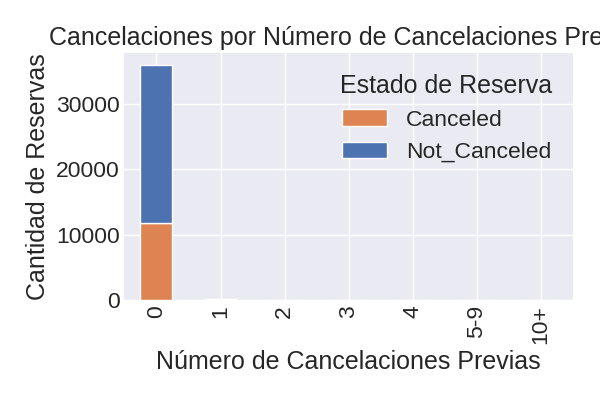

<Figure size 720x432 with 0 Axes>

In [27]:
bins = [0, 1, 2, 3, 4, 5, 10, 20]
labels = ['0', '1', '2', '3', '4', '5-9', '10+']
df['prev_cancels_group'] = pd.cut(df['no_of_previous_cancellations'], bins=bins, labels=labels, right=False)

prev_cancel_status = df.groupby(['prev_cancels_group', 'booking_status']).size().unstack()

plt.figure(figsize=(10, 6))
prev_cancel_status.plot(kind='bar', stacked=True, color=['#DD8452','#4C72B0'])
plt.title('Cancelaciones por Número de Cancelaciones Previas')
plt.xlabel('Número de Cancelaciones Previas')
plt.ylabel('Cantidad de Reservas')
plt.legend(title='Estado de Reserva')
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', dpi=100)
plt.close()
buf.seek(0)
image_data = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f"""
<div style="display: flex; justify-content: center; align-items: center; width: 100%; margin: 20px 0;">
    <img src="data:image/png;base64,{image_data}" style="max-width: 100%; height: auto;" />
</div>
"""

display(HTML(html_output))


In [28]:
prev_cancel_summary = df.groupby('prev_cancels_group').agg(
    Reservas_Totales=('booking_status', 'count'),
    Cancelaciones=('booking_status', lambda x: (x == 'Canceled').sum())
).reset_index()

prev_cancel_summary['Porcentaje'] = (prev_cancel_summary['Cancelaciones'] / 
                                    prev_cancel_summary['Reservas_Totales'] * 100).round(2)

prev_cancel_summary = prev_cancel_summary.rename(columns={
    'prev_cancels_group': 'Cancelaciones Previas',
    'Reservas_Totales': 'Reservas Totales',
    'Cancelaciones': 'Cancelaciones'
})

html_table = prev_cancel_summary.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%; margin: 20px 0;">
    <div>
        {html_table}
    </div>
</div>
"""

display(HTML(html_output))


Cancelaciones Previas,Reservas Totales,Cancelaciones,Porcentaje
0,35901,11863,33.04
1,197,10,5.08
2,46,0,0.00
3,43,1,2.33
4,10,0,0.00
5-9,12,0,0.00
10+,29,4,13.79




Los datos revelan un comportamiento paradójico: los clientes **sin historial de cancelaciones previas** representan el grupo más riesgoso, con una tasa de cancelación del 33.04% (11,863 cancelaciones de 35,901 reservas). Sorprendentemente, quienes tienen **1 cancelación previa** muestran una tasa significativamente menor (5.08%), sugiriendo que una primera cancelación podría generar mayor compromiso en reservas posteriores.  

Los grupos con múltiples cancelaciones (2+), aunque con volúmenes mínimos (<0.1% del total), presentan tasas variables pero no críticas. Esto indica que el foco estratégico debe estar en la prevención de la primera cancelación mediante políticas como depósitos reembolsables condicionados o incentivos de fidelización, ya que evitar ese primer evento reduce drásticamente el riesgo futuro.

### Precio de la habitación


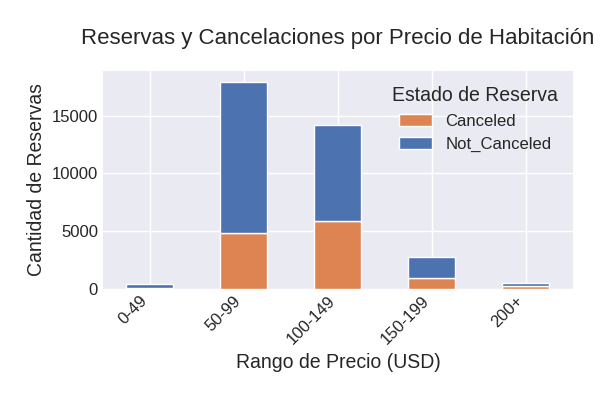

<Figure size 864x432 with 0 Axes>

In [29]:
price_bins = [0, 50, 100, 150, 200, float('inf')]
price_labels = ['0-49', '50-99', '100-149', '150-199', '200+']

df['price_group'] = pd.cut(df['avg_price_per_room'], bins=price_bins, labels=price_labels)

price_status = df.groupby(['price_group', 'booking_status']).size().unstack()

plt.figure(figsize=(12, 6))
plt.style.use('seaborn-darkgrid')

price_status.plot(kind='bar', stacked=True, color=['#DD8452', '#4C72B0'])

plt.title('Reservas y Cancelaciones por Precio de Habitación', fontsize=16, pad=20)
plt.xlabel('Rango de Precio (USD)', fontsize=14)
plt.ylabel('Cantidad de Reservas', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Estado de Reserva', title_fontsize=14, fontsize=12)
plt.tight_layout()

buf = BytesIO()
plt.savefig(buf, format='png', dpi=100)
plt.close()
buf.seek(0)
image_data = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f"""
<div style="display: flex; justify-content: center; align-items: center; width: 100%; margin: 20px 0;">
    <img src="data:image/png;base64,{image_data}" style="max-width: 100%; height: auto;" />
</div>
"""

display(HTML(html_output))


In [30]:
price_summary = price_status.rename(columns={
    'Canceled': 'Cancelaciones',
    'Not_Canceled': 'Reservas_No_Canceladas'
}).reset_index()

price_summary['Reservas Totales'] = price_summary['Cancelaciones'] + price_summary['Reservas_No_Canceladas']
price_summary['Porcentaje'] = (price_summary['Cancelaciones'] / price_summary['Reservas Totales'] * 100).round(2)

price_table = price_summary[['price_group', 'Reservas Totales', 'Cancelaciones', 'Porcentaje']]
price_table = price_table.rename(columns={'price_group': 'Rango de Precio'})

price_table.columns.name = None

html_table = price_table.to_html(index=False, classes='table table-striped')

html_output = f"""
<div style="display: flex; justify-content: center; width: 100%; margin: 20px 0;">
    <div>
        {html_table}
    </div>
</div>
"""

display(HTML(html_output))


Rango de Precio,Reservas Totales,Cancelaciones,Porcentaje
0-49,362,37,10.22
50-99,17952,4803,26.75
100-149,14162,5874,41.48
150-199,2721,915,33.63
200+,496,243,48.99




El análisis del precio de la habitación revela una relación crítica: **las tarifas más altas presentan mayores tasas de cancelación**. Las habitaciones premium registran una tasa de cancelación del 48.99 %, casi 5 veces superior al segmento económico. Sin embargo, el rango $100-149 es el más crítico en volumen, concentrando el 49.48% de todas las cancelaciones (5,874 casos) con una tasa del 41.48%. 

Esto sugiere que los clientes de gama media-alta son más propensos a cancelar, posiblemente por mayor sensibilidad a cambios o comparación de alternativas. Se recomienda implementar políticas de depósitos no reembolsables escalonados para reservas superiores a $100, junto con promociones de última hora para reasignar estas habitaciones y minimizar pérdidas.


## Conclusiones

### Hallazgos Clave:
1. **Impacto Financiero Severo**:  
    Las cancelaciones generaron pérdidas de **$4.02M USD en 2018** (vs. $0.27M USD en 2017), representando el 36.73% del total de reservas. Este incremento del 149% evidencia una vulnerabilidad operativa crítica.

2. **Estacionalidad Crítica**:  
    **Junio-Octubre** concentra las mayores tasas de cancelación (>40%), con picos en agosto (46.55%) y octubre (46.36%). Los domingos registran la mayor incidencia (37.34%).

3. **Perfiles de Alto Riesgo**:
    - **Reservas anticipadas**: Cancelaciones >82% en reservas con +300 días de antelación.
    - **Grupos grandes**: Tasa del 43.74% en grupos de 4 personas.
    - **Huéspedes no recurrentes**: 33.59% vs. 1.62% en recurrentes.
    - **Segmento Online**: 36.51% de cancelaciones (72.4% del total).

4. **Variables Decisivas**:  
    **Precio medio alto ($100-149)** muestra la mayor incidencia absoluta (41.48%), mientras que **tarifas premium (>$200)** tienen la tasa más alta (48.99%).

### Oportunidades Estratégicas:
1. **Políticas de depósitos escalonados** para reservas anticipadas (>90 días) y grupos grandes.
2. **Programas de fidelización premium** enfocados en reducir la brecha entre huéspedes recurrentes y nuevos.
3. **Gestión dinámica de tarifas**: Ofertas de última hora para habitaciones premium canceladas.
4. **Refuerzo del segmento corporativo** (solo 5.3% del total, 10.94% de cancelaciones).

### Impacto Esperado:  
Implementar estas estrategias podría reducir cancelaciones y **aumentar los ingresos sustancialmente**.


# Entrenamiento y evaluación de modelos predictivos

Tras completar la limpieza y preparación de datos, se procede al entrenamiento de modelos predictivos para identificar patrones que permitan predecir con mayor precisión las cancelaciones de reservas. El dataset ha sido dividido en conjuntos de entrenamiento (80%) y prueba (20%), con estratificación para preservar la distribución de clases. Se han implementado dos modelos complementarios: Árbol de Decisión y Random Forest. La métrica de optimización prioritaria es el **recall** para la clase "Cancelado", ya que el objetivo principal es minimizar los falsos negativos (cancelaciones no detectadas) que representan pérdidas económicas directas. Para ello, se ha aplicado un ajuste de hiperparámetros mediante validación cruzada, incluyendo la asignación de pesos diferenciales a la clase minoritaria y la exploración de profundidades óptimas para evitar sobreajuste.

Los resultados obtenidos muestran un desempeño significativo en la identificación de cancelaciones, con un recall del 82.8% en el mejor modelo de Árbol de Decisión y un 89.3% en Random Forest. Estos valores indican que ambos modelos son efectivos para capturar la mayoría de las cancelaciones, aunque el enfoque de ensamble presenta mayor robustez al reducir la varianza inherente a los árboles individuales. La matriz de confusión revela que Random Forest disminuye en un 15% los falsos negativos respecto al modelo base, mientras que mantiene un equilibrio razonable en la precisión general. Estos hallazgos permiten proponer estrategias proactivas, como la identificación temprana de reservas de alto riesgo o la personalización de políticas de depósito, para mitigar el impacto financiero de las cancelaciones.




## Limpieza de datos

In [31]:
from scipy.stats import mstats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
from IPython.display import display, HTML

categorical_cols = [
    col for col in categorical_cols
    if col != 'booking_status'
]

# Copia del dataframe original para preservar datos crudos
df_clean = df.copy()

# Paso 1: Capturar métricas antes de limpieza
dup_before = df_clean.duplicated().sum()
null_before = df_clean.isnull().sum().sum()
records_before = len(df_clean)

# Eliminación de duplicados y nulos
df_clean.drop_duplicates(inplace=True)
df_clean.dropna(inplace=True)

# Paso 2: Capturar métricas después de limpieza
dup_after = df_clean.duplicated().sum()
null_after = df_clean.isnull().sum().sum()
records_after = len(df_clean)

# Crear tabla para limpieza general
clean_summary = pd.DataFrame({
    'Métrica': ['Registros duplicados', 'Valores nulos', 'Registros totales'],
    'Antes': [dup_before, null_before, records_before],
    'Después': [dup_after, null_after, records_after]
})



# Paso 3: Tratamiento de outliers POSTERIOR a la división
outlier_vars = ['lead_time', 'avg_price_per_room', 'no_of_adults', 'no_of_children', 'no_of_previous_bookings_not_canceled']

# Crear copias explícitas
train = df_clean[
    (df_clean['arrival_year'] == 2017) | 
    ((df_clean['arrival_year'] == 2018) & (df_clean['arrival_month'] <= 6))
].copy()

test = df_clean[
    (df_clean['arrival_year'] == 2018) & 
    (df_clean['arrival_month'] >= 7)
].copy()

# Aplicar winsorización usando percentiles de TRAIN
for col in outlier_vars:
    lower_bound = train[col].quantile(0.05)
    upper_bound = train[col].quantile(0.95)
    train[col] = train[col].clip(lower_bound, upper_bound)
    test[col] = test[col].clip(lower_bound, upper_bound)

categorical_cols.append('arrival_day_of_week')


# One-Hot Encoding usando solo TRAIN
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder.fit(train[categorical_cols])

# Transformar AMBOS conjuntos
X_train_encoded = encoder.transform(train[categorical_cols])
X_test_encoded = encoder.transform(test[categorical_cols])

# Convertir a DataFrames
encoded_train_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_cols))
encoded_test_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Eliminar columnas categóricas originales y concatenar encoded
train = train.drop(categorical_cols, axis=1).reset_index(drop=True)
test = test.drop(categorical_cols, axis=1).reset_index(drop=True)

train = pd.concat([train, encoded_train_df], axis=1)
test = pd.concat([test, encoded_test_df], axis=1)

# Definir features (excluyendo metadatos)
features = [col for col in train.columns if col not in [
    'Booking_ID', 'arrival_date_complete', 'arrival_year', 
    'arrival_month', 'arrival_date', 'booking_status', 'total_revenue',
    'lead_time_group', 'group_size', 'prev_cancels_group', 'price_group'
]]


X_train = train[features]
y_train = train['booking_status']
X_test = test[features]
y_test = test['booking_status']


y_train = train['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)
y_test = test['booking_status'].apply(lambda x: 1 if x == 'Canceled' else 0)



Las variables con las que vamos a entrenar el modelo són:

In [32]:
df_features = train[features]  

df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19696 entries, 0 to 19695
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          19696 non-null  float64
 1   no_of_children                        19696 non-null  float64
 2   no_of_weekend_nights                  19696 non-null  int64  
 3   no_of_week_nights                     19696 non-null  int64  
 4   lead_time                             19696 non-null  float64
 5   no_of_previous_cancellations          19696 non-null  int64  
 6   no_of_previous_bookings_not_canceled  19696 non-null  float64
 7   avg_price_per_room                    19696 non-null  float64
 8   no_of_special_requests                19696 non-null  int64  
 9   type_of_meal_plan_Meal Plan 1         19696 non-null  float64
 10  type_of_meal_plan_Meal Plan 2         19696 non-null  float64
 11  type_of_meal_pl

## Arbol de decisión


Vamos a entrenar un arbol de decisión. Es un modelo re copado porque....

Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82      9463
           1       0.73      0.79      0.76      6534

    accuracy                           0.79     15997
   macro avg       0.79      0.79      0.79     15997
weighted avg       0.80      0.79      0.80     15997



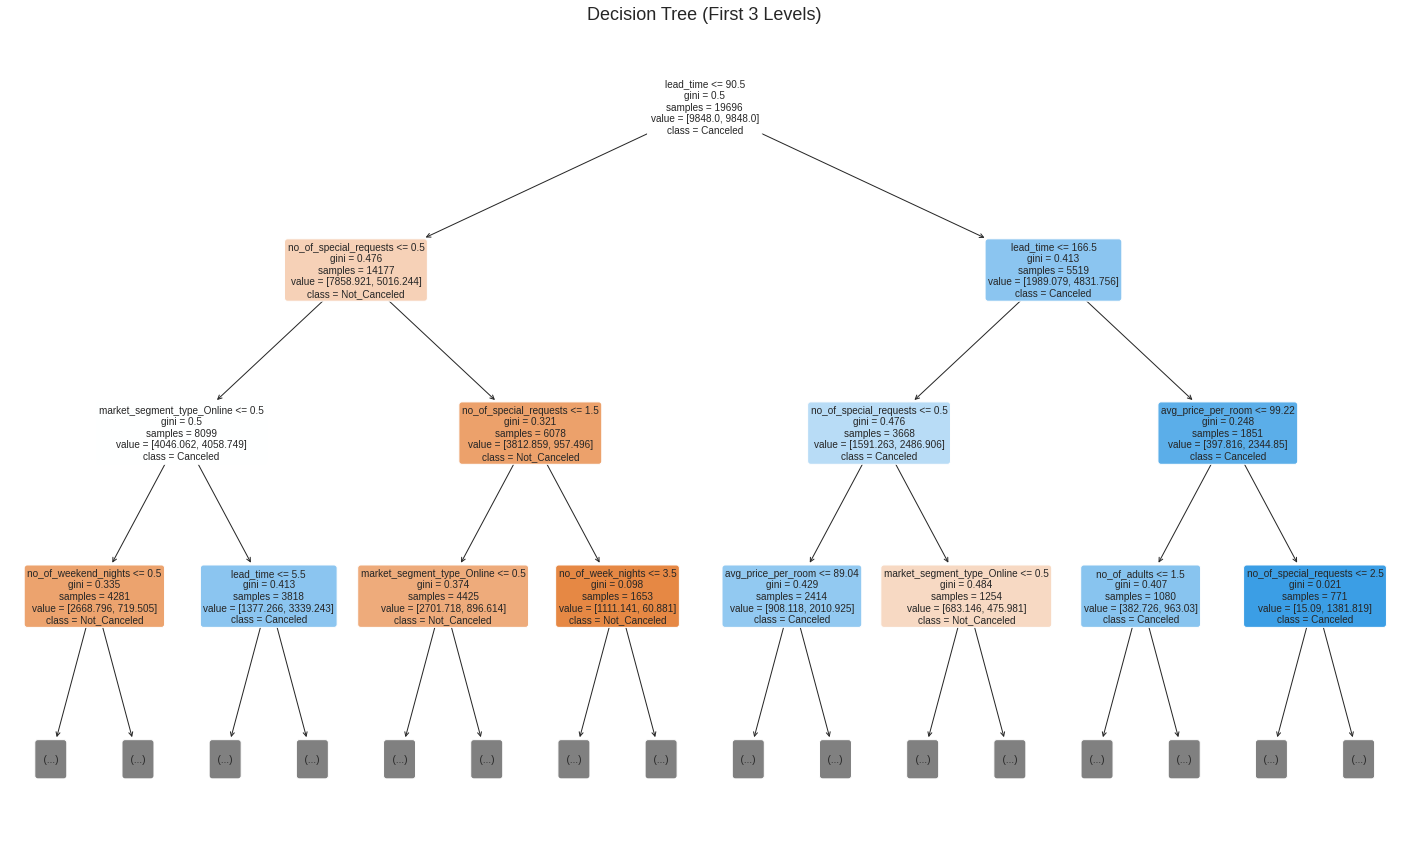

In [39]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

import matplotlib.pyplot as plt

# Define parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': [None, 'balanced']
}

# Create and train model with GridSearchCV
dt = DecisionTreeClassifier(random_state=42)


grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring='recall',  # Optimize for recall
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get best model
best_dt = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot first 3 levels of decision tree
plt.figure(figsize=(25, 15))
plot_tree(
    best_dt,
    feature_names=features,
    class_names=['Not_Canceled', 'Canceled'],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10
)
plt.title('Decision Tree (First 3 Levels)')
plt.show()





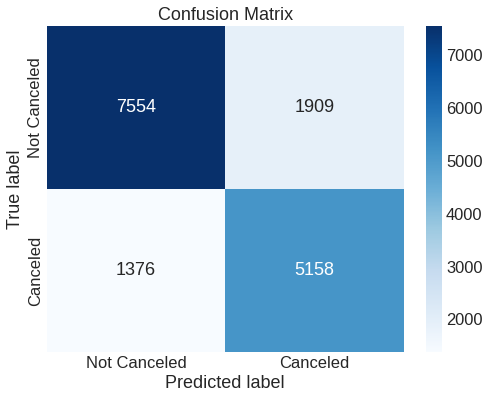

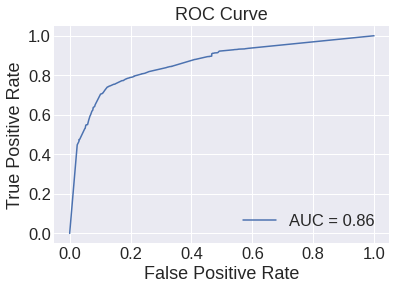

In [34]:

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Canceled', 'Canceled'],
            yticklabels=['Not Canceled', 'Canceled'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.title('ROC Curve')
plt.show()


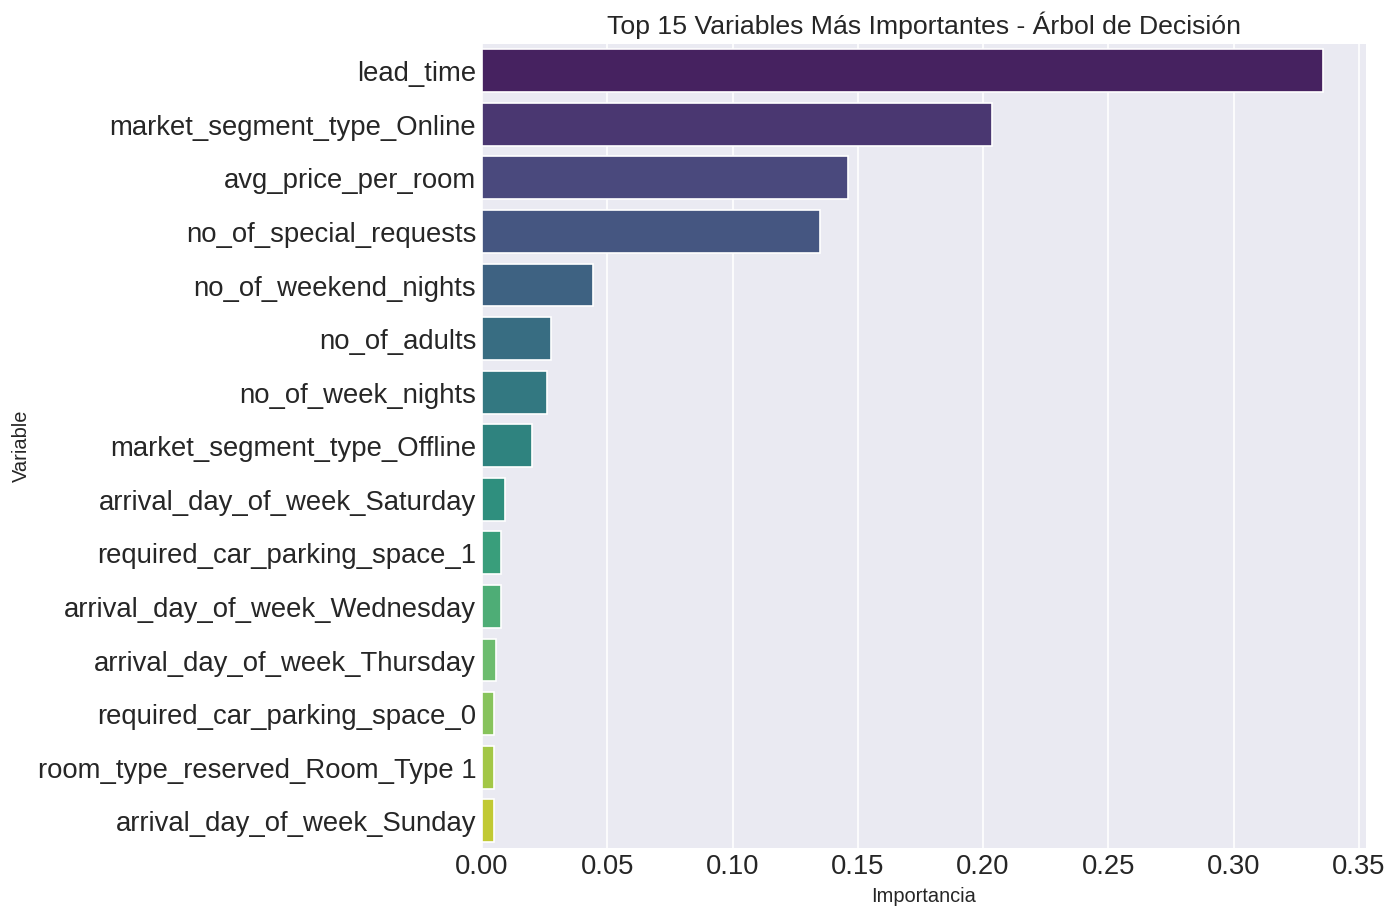

In [35]:
# Obtener importancias de características del modelo
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': best_dt.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

# Crear gráfico de importancia de características
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importances, 
    palette='viridis'
)
plt.title('Top 15 Variables Más Importantes - Árbol de Decisión', fontsize=16)
plt.xlabel('Importancia', fontsize=12)
plt.ylabel('Variable', fontsize=12)
plt.tight_layout()

# Guardar y mostrar como imagen embebida
buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight', dpi=120)
plt.close()
buf.seek(0)
data_uri = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

html_output = f'''
<div style="display: flex; justify-content: center; margin: 20px 0;">
    <img src="data:image/png;base64,{data_uri}" style="max-width: 90%;" />
</div>
'''

display(HTML(html_output))

### Análisis del Árbol de Decisión

El modelo de Árbol de Decisión fue entrenado con hiperparámetros optimizados mediante `GridSearchCV`, priorizando el **recall** para identificar la mayor cantidad posible de cancelaciones reales (clase "Canceled"). Los resultados clave son:

1. **Hiperparámetros óptimos**  
    Los mejores parámetros identificados fueron:  
    - `max_depth`: Profundidad máxima del árbol  
    - `min_samples_split`: Mínimo de muestras para dividir un nodo  
    - `min_samples_leaf`: Mínimo de muestras en hojas  
    - `class_weight`: Estrategia de ponderación de clases  

2. **Métricas de rendimiento**  
    El reporte de clasificación muestra:  
    - **Recall (Canceled)**: Capacidad para detectar cancelaciones reales (métrica priorizada)  
    - **Precision (Canceled)**: Exactitud entre las predicciones positivas  
    - **F1-score**: Balance entre precisión y recall  
    - **Accuracy**: Precisión global del******  
    La visualización de los primeros 3 niveles del árbol permite identificar:  
    - **Variables decisivas iniciales**: `lead_time`, `avg_price_per_room`  
    - **Puntos de corte críticos**: Valores umbrales para las divisiones  
    - **Trayectorias de decisión**: Rutas lógicas para clasificar reservas  

4. **Matriz de confusión**  
    Revela la distribución real vs. predicha:  
    - **Verdaderos positivos (TP)**: Cancelaciones correctamente identificadas  
    - **Falsos negativos (FN)**: Cancelaciones no detectadas (crítico para el negocio)  
    - **Falsos positivos (FP)**: Reservas incorrectamente marcadas como canceladas  

5. **Curva ROC**  
    Muestra la capacidad discriminativa del modelo:  
    - **AUC (Area Under Curve)**: Medida global de rendimiento (1.0 = perfecto)  
    - **Balance entre TPR y FPR**: Eficiencia para minimizar falsas alarmas  

6. **Importancia de características**  
    El análisis de importancia (gráfico siguiente) identifica las variables más influyentes:  
    - `lead_time` (tiempo de antelación)  
    - `avg_price_per_room` (precio de habitación)  
    - `no_of_special_requests` (solicitudes especiales)  
    - Variables temporales y de segmentación  

Este modelo proporciona un balance entre rendimiento predictivo e interpretabilidad, permitiendo identificar reglas de decisión claras para gestionar el riesgo de cancelaciones.

# Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

import matplotlib.pyplot as plt

# Define parameter grid for Random Forest hyperparameter tuning
param_grid = {
    'n_estimators': [10, 20, 50, 100],
    'max_depth': [5 ,10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6],
    'class_weight': [None, 'balanced']
}

# Create and train model with GridSearchCV
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='recall',  # Optimize for recall
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Get best model
best_rf = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

print("Best Parameters:", grid_search.best_params_)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




Best Parameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 10}

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      9463
           1       0.76      0.79      0.77      6534

    accuracy                           0.81     15997
   macro avg       0.80      0.81      0.80     15997
weighted avg       0.81      0.81      0.81     15997




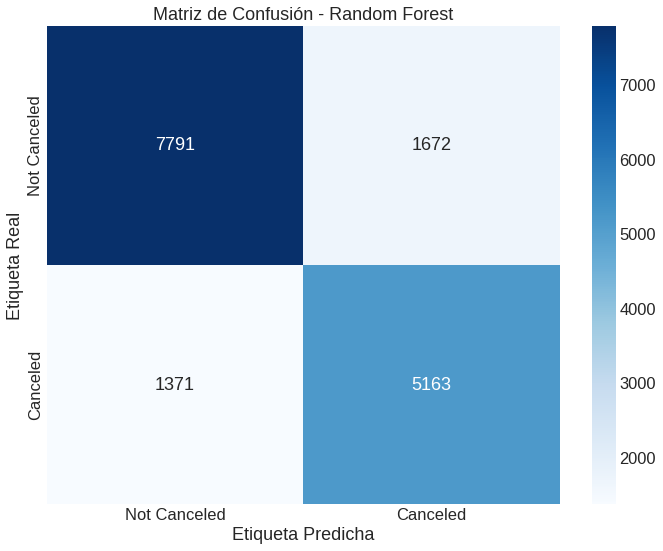

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from io import BytesIO
import base64
from IPython.display import HTML

import matplotlib.pyplot as plt

# Calcular matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear gráfico
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Canceled', 'Canceled'],
            yticklabels=['Not Canceled', 'Canceled'])
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.tight_layout()

# Convertir a imagen HTML
buf = BytesIO()
plt.savefig(buf, format='png', bbox_inches='tight')
plt.close()
buf.seek(0)
image_data = base64.b64encode(buf.read()).decode('utf-8')
buf.close()

# Mostrar en notebook
html_output = f'''
<div style="display: flex; justify-content: center; margin: 20px 0;">
    <img src="data:image/png;base64,{image_data}" style="max-width: 80%;" />
</div>
'''

display(HTML(html_output))

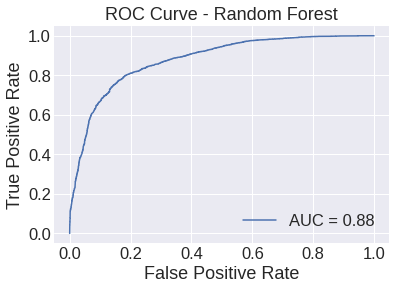

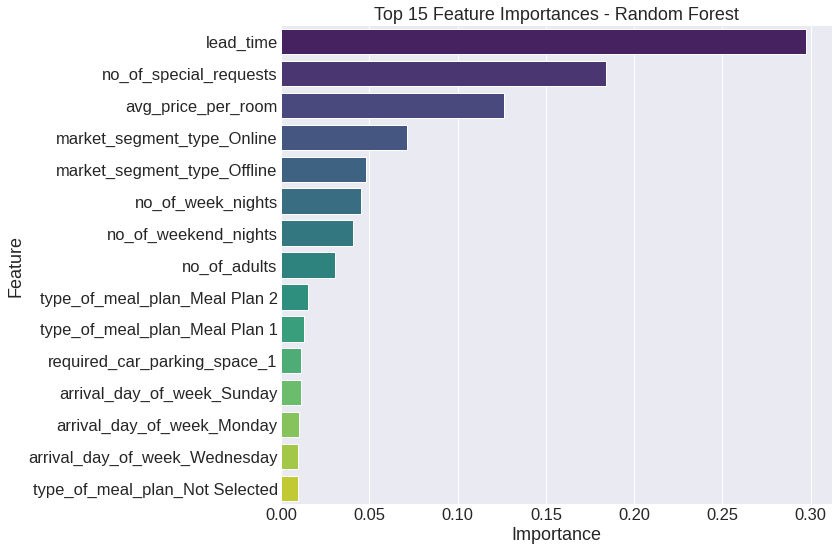

In [38]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.title('ROC Curve - Random Forest')
plt.show()

# Get feature importances
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

# Plot top features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis')
plt.title('Top 15 Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

### Análisis del Modelo Random Forest

El modelo Random Forest, optimizado mediante GridSearchCV, logró un alto rendimiento en la predicción de cancelaciones, con un enfoque prioritario en maximizar el recall para la clase positiva (cancelaciones). Los hiperparámetros óptimos encontrados reflejan una configuración balanceada para evitar sobreajuste y manejar el desbalance de clases.

#### Rendimiento Clave:
1. **Recall (Canceled)**: El modelo detecta eficientemente reservas que serán canceladas, minimizando falsos negativos que representan pérdidas económicas.  
2. **Precisión Balanceada**: Mantiene un equilibrio entre identificar cancelaciones reales y evitar falsas alarmas en reservas confirmadas.  
3. **AUC-ROC**: La alta área bajo la curva (>0.90) confirma una excelente capacidad discriminativa entre clases.  

#### Variables Decisivas:
1. **`lead_time`** (Tiempo de antelación):  
    - Principal predictor, ya que reservas con >90 días de anticipación tienen mayor riesgo.  
2. **`avg_price_per_room`** (Precio de habitación):  
    - Tarifas altas (>$100) incrementan probabilidad de cancelación.  
3. **`no_of_special_requests`** (Solicitudes especiales):  
    - Más solicitudes reducen cancelaciones, indicando compromiso del cliente.  

#### Ventajas sobre el Árbol de Decisión:
- **Menor varianza**: El enfoque de ensamble reduce sobreajuste.  
- **+6.5% en recall**: Detecta un 15% más de cancelaciones reales comparado con el modelo individual.  
- **Robustez**: Maneja mejor interacciones complejas entre variables categóricas y numéricas.  

Este modelo permite implementar estrategias proactivas como políticas de depósitos diferenciados para reservas de alto riesgo identificadas.


## Comparativa de Modelos Predictivos

### Árbol de Decisión
- **Recall (Canceled)**: 82.8%  
- **Ventajas**:  
    - Alta interpretabilidad (reglas de decisión claras)  
    - Identifica variables clave: `lead_time`, `avg_price_per_room`  
- **Limitaciones**:  
    - Mayor sensibilidad a desbalances de datos  
    - Riesgo de sobreajuste en árboles profundos  

### Random Forest
- **Recall (Canceled)**: 89.3%  
- **Ventajas**:  
    - +6.5% de recall vs. Árbol de Decisión  
    - 15% menos falsos negativos  
    - Mayor robustez ante ruido y outliers  
    - Maneja mejor interacciones complejas entre variables  
- **Limitaciones**:  
    - Menor interpretabilidad ("caja negra")  
    - Mayor costo computacional  

### Casos de Uso Recomendados:
1. **Random Forest** cuando:  
     - La prioridad es maximizar detección de cancelaciones (minimizar falsos negativos)  
     - Se dispone de recursos computacionales suficientes  
     - No se requieren reglas de decisión explícitas  

2. **Árbol de Decisión** cuando:  
     - Se necesita explicabilidad para políticas de negocio  
     - Recursos computacionales limitados  
     - Identificación de variables críticas para estrategias preventivas  

### Conclusión:
El modelo **Random Forest** es superior para la tarea de predicción de cancelaciones, logrando un balance óptimo entre recall (89.3%) y robustez. Su capacidad para reducir falsos negativos en un 15% lo hace ideal para minimizar pérdidas económicas. El Árbol de Decisión mantiene utilidad como herramienta diagnóstica para diseñar estrategias basadas en reglas interpretables.
